# Installations


In [2]:
# Clone the SAM2 repository
!git clone https://github.com/SysCV/sam-hq.git

# Navigate to the repository directory
%cd sam-hq

# Install the necessary dependencies
!pip install -e .

# Install PyTorch (make sure it's compatible with your environment)
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # Adjust CUDA version as needed


fatal: destination path 'sam-hq' already exists and is not an empty directory.
/content/sam-hq
Obtaining file:///content/sam-hq
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment_anything
    Found existing installation: segment_anything 1.0
    Uninstalling segment_anything-1.0:
      Successfully uninstalled segment_anything-1.0
  Running setup.py develop for segment_anything


In [ ]:
!pip install timm==0.4.12 --no-deps

In [3]:
!pip install torch==2.4.0

  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl (797.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 2.4.0 which is incompatible.
torchvision 0.19.1+cu121 requires torch==2.4.1, but you have torch 2.4.0 which is incompatible.


In [4]:
!git clone https://gitlab.com/fruitpunch/projects/ai-for-coral-reefs-2/unsupervised-learning/packages.git

Cloning into 'packages'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 85 (delta 11), reused 0 (delta 0), pack-reused 43 (from 1)
Receiving objects: 100% (85/85), 87.62 KiB | 6.26 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [5]:
!pip install torchmetrics --no-deps
!pip install lightning_utilities --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 26.2 MB/s eta 0:00:00


In [6]:
# workaround to overcome long duration needed for installing torch_scatter
import torch
!pip install pyg_lib torch_scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 36.1 MB/s eta 0:00:00


# Import

In [4]:
import os
import pandas as pd
from google.colab import drive
import numpy as np
import yaml
import shutil
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from pathlib import Path

import logging
logger = logging.getLogger(__name__)
# Set the logging level (optional)
logger.setLevel(logging.DEBUG)

DRIVE_MOUNT_DIR = '/content/drive'
drive.mount(DRIVE_MOUNT_DIR, force_remount=True)

Mounted at /content/drive


In [5]:
import sys # add the path where point label aware superpixels and custom packags is located
sys.path.append(os.path.join('/content/sam-hq', 'packages'))

from labelmate.loader import LabelPropDataLoader
from labelmate.patchifier import SimplePatchifier
from labelmate.visualizer import visualize_output
from labelmate.evaluator import LabelPropEvaluator
from labelmate.propagator import PLASPIXLabelProp, SAMPointPromptsLabelProp

In [6]:
# quadratid= '20046281801'
# val_qudratid=['20046281801']
folder='SEAVIEW_ATL'
region='ATL'
PROJECT_ROOT_DIR = os.path.join(DRIVE_MOUNT_DIR, 'My Drive', 'challenge_2')
REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH = os.path.join(PROJECT_ROOT_DIR, '01_Data', 'benthic_datasets', 'point_labels', 'SEAVIEW' , 'tabular-data', f'annotations_{region}.csv')

point_labels_df = pd.read_csv(REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH, header='infer')
point_labels_df['class_label'] = np.where(
    point_labels_df['func_group'] == 'Hard Coral', 1,  # First condition
    np.where(point_labels_df['func_group'] == 'Soft Coral', 2, 0)  # Second condition
)
point_labels_df['quadratid']=point_labels_df['quadratid'].astype(str)
# point_labels_df=point_labels_df[point_labels_df['quadratid']==quadratid]
point_labels_df

quadratid    y    x               label_name    label  func_group  \
0      17001738002  180  183                     Fish     FISH       Other   
1      17001738002  199  162                      CCA      CCA       Algae   
2      17001738002  197  160                      CCA      CCA       Algae   
3      17001738002   88  561                     Turf     Turf       Algae   
4      17001738002  195  714                 Ocomplex     OCOM  Hard Coral   
...            ...  ...  ...                      ...      ...         ...   
92895  21011130002  619  738  Pseudodiploria bleached  PSEU-BL  Hard Coral   
92896  21011130002  535  751  Pseudodiploria bleached  PSEU-BL  Hard Coral   
92897  21011130002  458  555  Pseudodiploria bleached  PSEU-BL  Hard Coral   
92898  21011130002  409  539  Pseudodiploria bleached  PSEU-BL  Hard Coral   
92899  21011130002  446  697  Pseudodiploria bleached  PSEU-BL  Hard Coral   

       method data_set  class_label  
0      random     test            0  
1      random     test            0  
2      random     test            0  
3      random     test            0  
4      random     test            1  
...       ...      ...          ...  
92895  target    train            1  
92896  target    train            1  
92897  target    train            1  
92898  target    train            1  
92899  target    train            1  

[92900 rows x 9 columns]

In [7]:
images = os.listdir(os.path.join(PROJECT_ROOT_DIR, "01_Data", "benthic_datasets", "mask_labels", "reef_support", f"SEAVIEW_{region}", "images"))
images = [image.replace('.jpg','') for image in images]

point_labels_df = point_labels_df[point_labels_df['quadratid'].isin(images)]

# Selecting only subset of images
grouped_df = point_labels_df.groupby('quadratid').agg(
    point_count=('class_label', 'count'),
    label_count=('class_label', 'nunique')
).reset_index()
grouped_df1=sorted(grouped_df[(grouped_df['point_count']==50)&(grouped_df['label_count']==1)]['quadratid'].tolist())[0:5]
grouped_df2=sorted(grouped_df[(grouped_df['point_count']==50)&(grouped_df['label_count']==2)]['quadratid'].tolist())[0:5]
grouped_df3=sorted(grouped_df[(grouped_df['point_count']==50)&(grouped_df['label_count']==3)]['quadratid'].tolist())[0:20]

grouped_df4=sorted(grouped_df[(grouped_df['point_count']==100)&(grouped_df['label_count']==1)]['quadratid'].tolist())[0:5]
grouped_df5=sorted(grouped_df[(grouped_df['point_count']==100)&(grouped_df['label_count']==2)]['quadratid'].tolist())[0:5]
grouped_df6=sorted(grouped_df[(grouped_df['point_count']==100)&(grouped_df['label_count']==3)]['quadratid'].tolist())[0:20]

grouped_df7=sorted(grouped_df[(grouped_df['point_count']==150)&(grouped_df['label_count']==1)]['quadratid'].tolist())[0:5]
grouped_df8=sorted(grouped_df[(grouped_df['point_count']==150)&(grouped_df['label_count']==2)]['quadratid'].tolist())[0:5]
grouped_df9=sorted(grouped_df[(grouped_df['point_count']==150)&(grouped_df['label_count']==3)]['quadratid'].tolist())[0:20]
sampled_quadids=grouped_df1+grouped_df2+grouped_df3+grouped_df4+grouped_df5+grouped_df6+grouped_df7+grouped_df8+grouped_df9+['20046281801','25016137702']
print(len(sampled_quadids))

63


In [8]:
if os.path.exists('/content/datasets'):
  shutil.rmtree('/content/datasets')
os.mkdir('/content/datasets')
os.mkdir('/content/datasets/images')
os.mkdir('/content/datasets/masks')
os.mkdir('/content/datasets/predicted_masks')

if not os.path.exists('/content/weights'):
  os.mkdir('/content/weights')

if not os.path.exists('/content/weights/sam-hq'):
  os.mkdir('/content/weights/sam-hq')

In [9]:
%cd /content/sam-hq

/content/sam-hq


In [10]:
from segment_anything import SamPredictor, sam_model_registry


# Load and prepare your image
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_resized = cv2.resize(image, (256, 256))  # Resize to 1024x1024
    return image

# sam_hq = sam_model_registry["vit_h"](checkpoint="/content/weights/sam-hq/sam_hq_vit_h.pth")
# sam_hq = sam_model_registry["vit_tiny"](checkpoint="/content/weights/sam-hq/sam_hq_vit_tiny.pth")
sam_hq = sam_model_registry["vit_b"](checkpoint="/content/weights/sam-hq/sam_hq_vit_b.pth")

# Initialize the predictor
predictor = SamPredictor(sam_hq)

/content/sam-hq/segment_anything/build_sam.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=device)


<All keys matched successfully>


Quadrat Id in progress:  17006011402


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[214, 186], [271, 178], [268, 64], [569, 112], [457, 118], [773, 194], [717, 86], [737, 68], [979, 144], [970, 138], [881, 55], [913, 85], [77, 364], [153, 337], [703, 302], [690, 363], [650, 320], [896, 362], [56, 443], [70, 503], [203, 606], [393, 552], [483, 539], [709, 494], [645, 517], [654, 602], [827, 558], [923, 453], [105, 714], [245, 732], [280, 665], [501, 703], [604, 658], [548, 625], [471, 769], [654, 736], [793, 691], [700, 707], [730, 683], [703, 631], [691, 629], [835, 657], [158, 911], [168, 917], [494, 850], [523, 891], [768, 827], [759, 811], [785, 820], [657, 826]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__

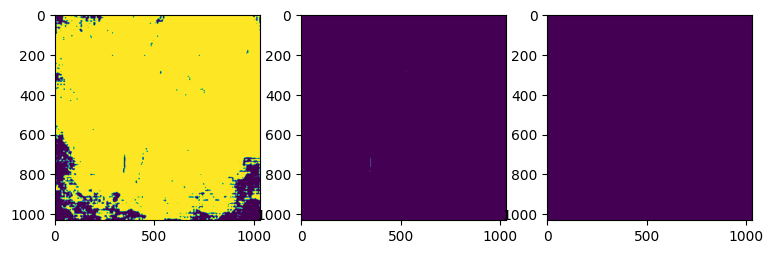

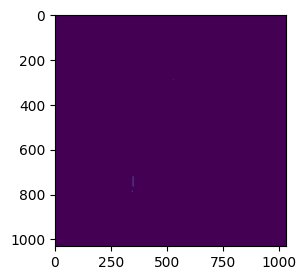

Predicted mask saved at: /content/datasets/predicted_masks/17006011402.png
Quadrat Id in progress:  17006011602


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[174, 125], [120, 133], [173, 210], [328, 123], [388, 175], [524, 188], [644, 110], [694, 183], [848, 166], [874, 81], [409, 322], [355, 367], [443, 269], [562, 367], [737, 242], [762, 392], [628, 382], [744, 252], [701, 266], [969, 261], [898, 388], [429, 479], [871, 449], [858, 468], [883, 485], [178, 712], [224, 634], [207, 792], [285, 669], [569, 738], [572, 710], [559, 655], [432, 741], [752, 726], [763, 703], [792, 720], [743, 624], [670, 704], [624, 731], [906, 698], [836, 643], [965, 686], [210, 864], [589, 908], [451, 961], [738, 873], [662, 930], [900, 836], [842, 966], [939, 954]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:_

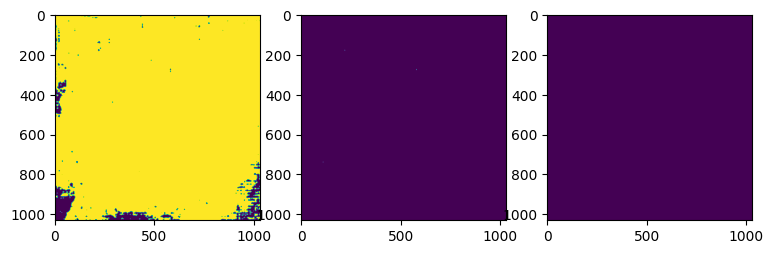

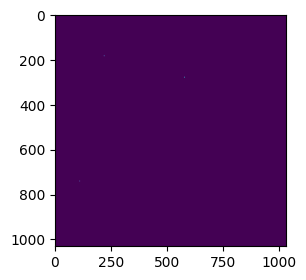

Predicted mask saved at: /content/datasets/predicted_masks/17006011602.png
Quadrat Id in progress:  17006011802


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[192, 161], [162, 81], [188, 76], [334, 153], [369, 225], [372, 199], [587, 144], [516, 60], [967, 184], [202, 307], [369, 241], [244, 252], [418, 349], [971, 394], [891, 395], [107, 428], [69, 548], [228, 596], [70, 609], [70, 530], [241, 454], [392, 427], [324, 569], [315, 595], [581, 436], [583, 472], [463, 502], [596, 605], [793, 524], [611, 429], [822, 608], [842, 509], [912, 545], [831, 503], [844, 439], [208, 682], [225, 616], [399, 647], [348, 750], [272, 761], [646, 750], [723, 680], [804, 776], [60, 818], [159, 972], [410, 956], [251, 895], [895, 858], [868, 813], [869, 887]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main_

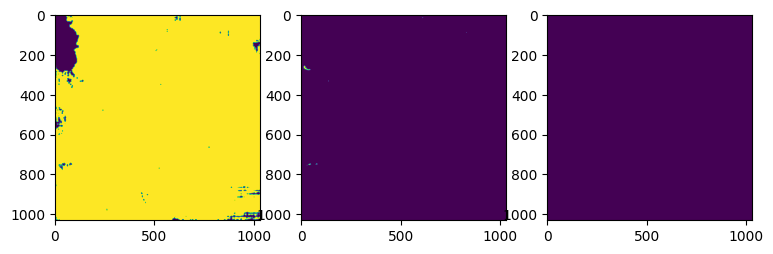

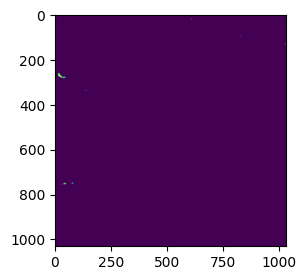

Predicted mask saved at: /content/datasets/predicted_masks/17006011802.png
Quadrat Id in progress:  17037006802


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[130, 104], [382, 86], [301, 166], [404, 94], [566, 195], [595, 122], [896, 155], [849, 140], [89, 282], [103, 411], [119, 238], [90, 313], [213, 325], [300, 332], [299, 411], [324, 273], [450, 418], [743, 327], [742, 272], [856, 255], [915, 314], [907, 422], [68, 520], [136, 467], [171, 551], [279, 605], [280, 476], [529, 598], [483, 589], [587, 444], [695, 543], [834, 465], [218, 664], [189, 616], [369, 763], [497, 774], [441, 689], [713, 662], [655, 651], [765, 645], [617, 683], [816, 615], [297, 819], [359, 852], [548, 811], [677, 897], [884, 969], [906, 918], [957, 908], [916, 950]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

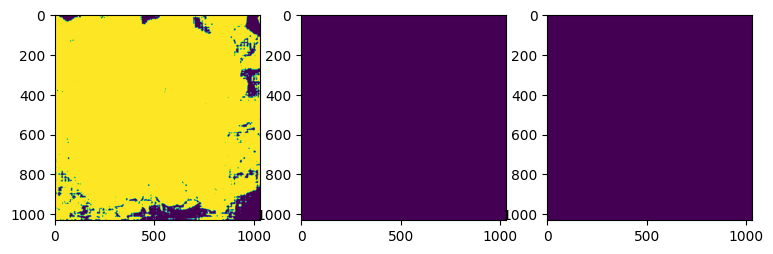

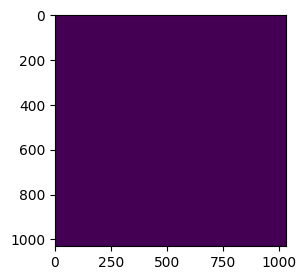

Predicted mask saved at: /content/datasets/predicted_masks/17037006802.png
Quadrat Id in progress:  20046223601


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[267, 218], [441, 248], [341, 170], [313, 175], [364, 102], [306, 75], [423, 202], [757, 138], [703, 236], [861, 215], [1023, 256], [1013, 180], [227, 310], [125, 389], [239, 479], [194, 281], [333, 407], [461, 312], [286, 417], [550, 312], [655, 446], [1037, 477], [1000, 368], [61, 571], [73, 625], [413, 650], [616, 482], [653, 571], [679, 605], [1087, 577], [960, 682], [212, 859], [257, 747], [269, 812], [549, 736], [536, 795], [637, 829], [688, 856], [498, 710], [914, 736], [117, 1054], [82, 1005], [108, 1000], [197, 919], [102, 1035], [415, 905], [305, 1039], [726, 961], [711, 1110], [1008, 1020]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 

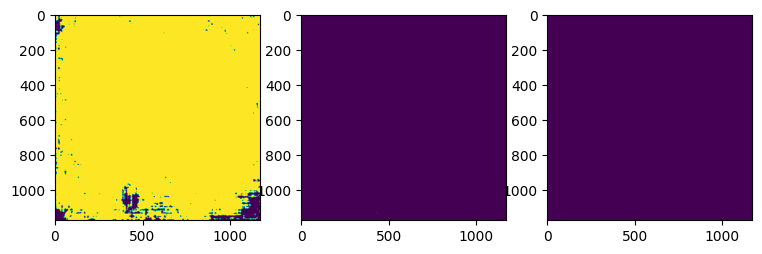

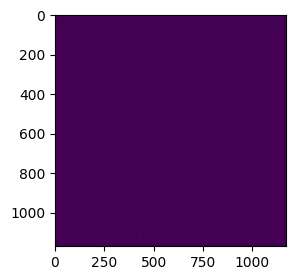

Predicted mask saved at: /content/datasets/predicted_masks/20046223601.png
Quadrat Id in progress:  17001738202


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[162, 137], [149, 206], [202, 221], [361, 218], [268, 79], [322, 181], [439, 68], [521, 156], [504, 219], [712, 232], [880, 163], [950, 105], [126, 379], [198, 332], [383, 351], [373, 288], [379, 396], [463, 408], [473, 279], [467, 352], [435, 289], [785, 360], [731, 317], [800, 238], [98, 595], [203, 567], [307, 453], [478, 547], [437, 551], [632, 596], [610, 564], [91, 615], [278, 677], [585, 634], [581, 766], [491, 780], [735, 734], [646, 647], [900, 709], [842, 701], [820, 736], [848, 714], [370, 811], [661, 937], [610, 855], [630, 798], [643, 872], [617, 847], [746, 952], [933, 827]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__ma

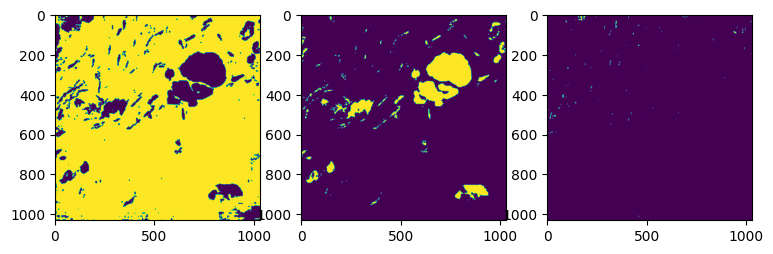

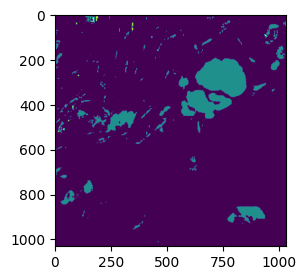

Predicted mask saved at: /content/datasets/predicted_masks/17001738202.png
Quadrat Id in progress:  17001738302


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[61, 220], [370, 98], [297, 165], [523, 199], [915, 206], [191, 324], [270, 350], [511, 250], [760, 337], [703, 289], [739, 261], [716, 280], [681, 402], [829, 369], [843, 317], [798, 324], [66, 434], [436, 471], [523, 609], [651, 517], [788, 463], [797, 471], [825, 558], [980, 433], [91, 793], [356, 706], [480, 642], [497, 636], [463, 793], [610, 631], [652, 655], [850, 770], [206, 917], [158, 976], [384, 940], [537, 941], [590, 860], [451, 875], [478, 968], [631, 923], [656, 907], [771, 873], [631, 860], [726, 811], [624, 844], [954, 800], [964, 900], [925, 857], [831, 814], [901, 969]]
DEBUG:__main__:Point Labels: [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__ma

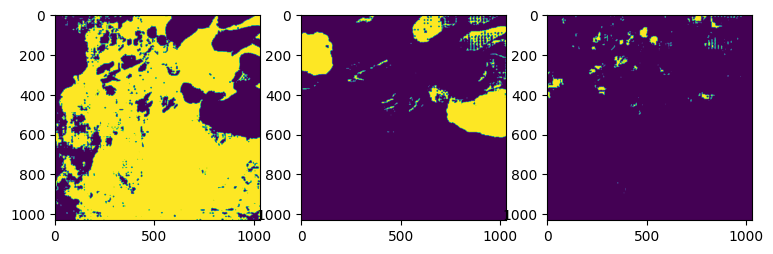

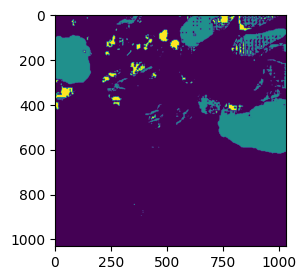

Predicted mask saved at: /content/datasets/predicted_masks/17001738302.png
Quadrat Id in progress:  17001738402


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[159, 139], [134, 186], [160, 162], [394, 210], [311, 182], [448, 177], [519, 187], [456, 95], [449, 112], [650, 151], [630, 64], [632, 171], [816, 190], [916, 158], [837, 79], [326, 295], [640, 256], [890, 363], [289, 526], [478, 424], [573, 551], [483, 535], [580, 604], [904, 438], [896, 469], [219, 710], [374, 725], [368, 770], [557, 662], [513, 717], [470, 656], [646, 681], [770, 733], [818, 670], [828, 646], [952, 646], [911, 754], [130, 898], [218, 980], [413, 865], [356, 874], [281, 941], [411, 871], [404, 887], [468, 843], [662, 919], [685, 908], [976, 901], [852, 980], [952, 880]]
DEBUG:__main__:Point Labels: [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__m

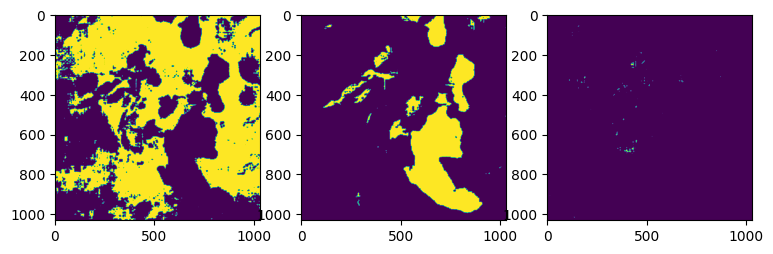

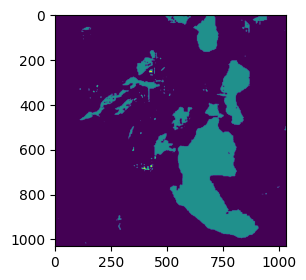

Predicted mask saved at: /content/datasets/predicted_masks/17001738402.png
Quadrat Id in progress:  17001739802


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[186, 157], [319, 212], [596, 67], [516, 211], [700, 217], [748, 126], [967, 212], [226, 305], [178, 303], [231, 263], [211, 261], [257, 369], [557, 244], [493, 409], [778, 350], [662, 333], [862, 323], [974, 402], [227, 573], [64, 477], [263, 426], [790, 444], [616, 474], [630, 427], [700, 580], [680, 432], [931, 431], [169, 653], [274, 666], [590, 651], [592, 657], [521, 638], [451, 672], [462, 763], [563, 685], [446, 655], [537, 739], [744, 719], [797, 675], [858, 748], [851, 678], [179, 952], [70, 977], [511, 841], [477, 958], [592, 830], [725, 972], [770, 962], [721, 908], [970, 839]]
DEBUG:__main__:Point Labels: [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__m

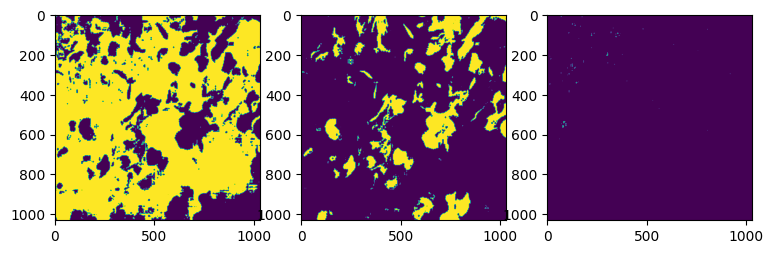

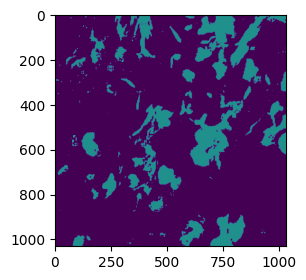

Predicted mask saved at: /content/datasets/predicted_masks/17001739802.png
Quadrat Id in progress:  17001740402


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[78, 56], [168, 92], [244, 160], [307, 76], [487, 129], [507, 79], [454, 122], [641, 85], [853, 191], [874, 213], [807, 78], [978, 79], [949, 194], [162, 367], [141, 346], [288, 410], [296, 239], [263, 306], [327, 380], [694, 306], [719, 359], [932, 269], [955, 408], [193, 517], [131, 450], [317, 467], [251, 515], [440, 481], [748, 444], [792, 560], [844, 476], [957, 495], [901, 582], [157, 676], [380, 614], [612, 642], [633, 781], [918, 661], [946, 738], [168, 950], [224, 928], [220, 976], [308, 892], [574, 965], [442, 908], [535, 863], [631, 861], [656, 962], [742, 891], [811, 908]]
DEBUG:__main__:Point Labels: [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__

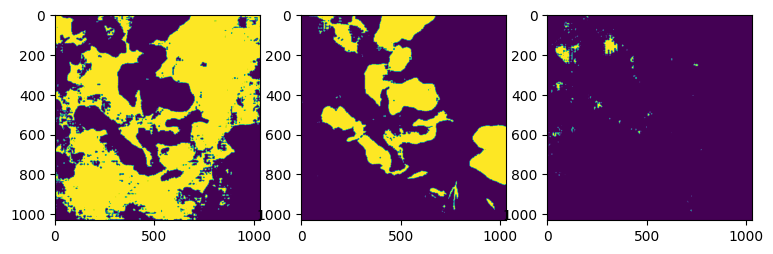

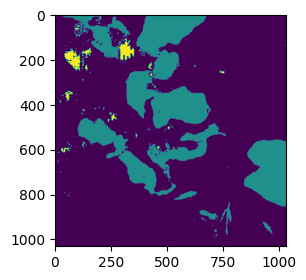

Predicted mask saved at: /content/datasets/predicted_masks/17001740402.png
Quadrat Id in progress:  17001738102


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[56, 182], [72, 81], [157, 120], [397, 108], [305, 127], [442, 188], [614, 58], [793, 177], [681, 104], [881, 184], [802, 116], [394, 287], [507, 420], [822, 244], [902, 279], [356, 599], [269, 584], [426, 524], [461, 553], [603, 537], [448, 543], [566, 570], [655, 494], [657, 518], [694, 511], [730, 591], [741, 490], [266, 756], [320, 711], [317, 740], [362, 704], [510, 767], [428, 627], [712, 709], [697, 629], [919, 696], [207, 811], [287, 804], [306, 892], [241, 904], [338, 802], [620, 899], [652, 927], [661, 971], [662, 857], [979, 970], [964, 939], [925, 838], [824, 927], [829, 867]]
DEBUG:__main__:Point Labels: [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__ma

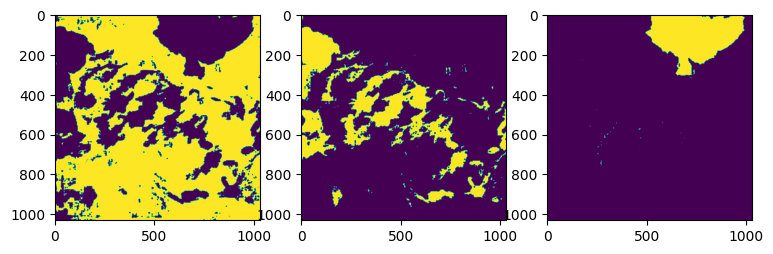

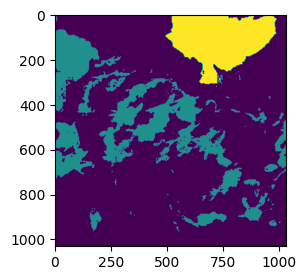

Predicted mask saved at: /content/datasets/predicted_masks/17001738102.png
Quadrat Id in progress:  17001738502


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[177, 117], [140, 191], [224, 129], [147, 163], [93, 178], [87, 105], [316, 173], [489, 227], [574, 207], [489, 67], [745, 106], [753, 176], [775, 113], [627, 190], [965, 76], [849, 125], [84, 289], [319, 353], [256, 306], [329, 292], [392, 283], [472, 337], [515, 332], [690, 347], [648, 340], [762, 244], [807, 382], [333, 444], [266, 507], [520, 535], [673, 466], [692, 523], [672, 555], [690, 544], [819, 578], [834, 505], [922, 536], [389, 642], [364, 750], [256, 723], [556, 779], [670, 631], [752, 691], [914, 635], [168, 965], [169, 800], [327, 833], [574, 904], [493, 810], [763, 816]]
DEBUG:__main__:Point Labels: [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

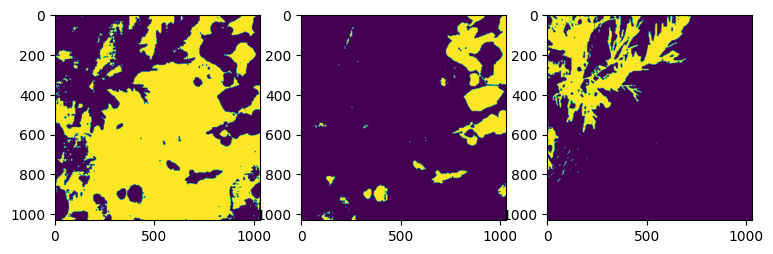

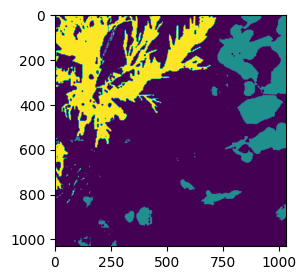

Predicted mask saved at: /content/datasets/predicted_masks/17001738502.png
Quadrat Id in progress:  17001738602


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[128, 201], [170, 135], [145, 222], [240, 228], [346, 170], [531, 137], [585, 223], [755, 165], [712, 100], [916, 121], [836, 143], [851, 54], [235, 305], [360, 408], [346, 316], [573, 268], [636, 333], [755, 242], [829, 320], [137, 530], [135, 437], [183, 478], [121, 474], [276, 426], [484, 479], [536, 440], [621, 536], [792, 582], [729, 587], [903, 538], [906, 505], [801, 453], [92, 710], [146, 752], [123, 761], [357, 654], [341, 786], [433, 629], [517, 623], [482, 662], [895, 782], [854, 764], [388, 826], [266, 843], [322, 853], [442, 828], [790, 972], [728, 877], [752, 884], [832, 832]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__

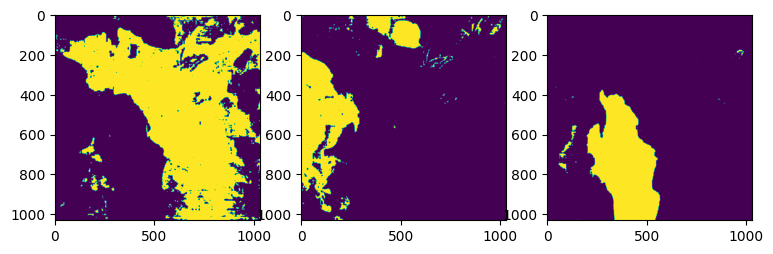

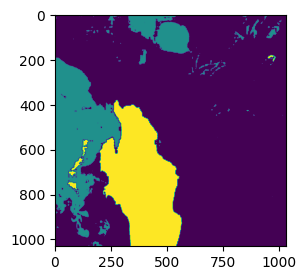

Predicted mask saved at: /content/datasets/predicted_masks/17001738602.png
Quadrat Id in progress:  17001738702


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[225, 163], [135, 210], [181, 63], [247, 154], [287, 81], [548, 225], [921, 195], [810, 148], [865, 181], [803, 116], [261, 334], [411, 252], [408, 371], [594, 252], [466, 412], [559, 373], [596, 322], [775, 264], [674, 308], [942, 377], [839, 393], [208, 602], [247, 567], [505, 547], [549, 456], [533, 547], [595, 538], [573, 477], [471, 550], [583, 472], [972, 466], [76, 709], [255, 630], [284, 617], [460, 732], [532, 685], [619, 766], [641, 638], [799, 741], [944, 623], [853, 753], [914, 717], [55, 913], [70, 811], [301, 907], [263, 935], [341, 956], [544, 804], [424, 807], [656, 919]]
DEBUG:__main__:Point Labels: [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

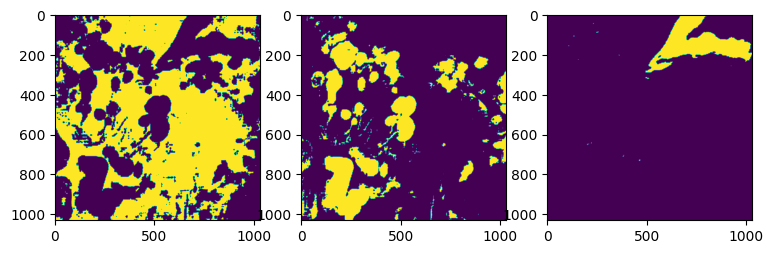

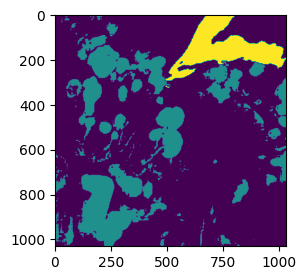

Predicted mask saved at: /content/datasets/predicted_masks/17001738702.png
Quadrat Id in progress:  17001738902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[203, 112], [201, 213], [90, 186], [52, 72], [253, 63], [645, 225], [783, 117], [681, 88], [958, 224], [814, 99], [169, 326], [309, 341], [515, 300], [600, 351], [598, 363], [567, 392], [481, 387], [700, 250], [666, 313], [831, 328], [236, 582], [258, 532], [559, 483], [584, 468], [615, 447], [653, 560], [792, 604], [817, 511], [881, 609], [236, 791], [190, 669], [247, 785], [292, 764], [518, 662], [595, 713], [545, 781], [769, 735], [897, 768], [958, 697], [335, 895], [304, 963], [421, 962], [486, 843], [479, 818], [554, 954], [458, 873], [481, 941], [705, 910], [970, 954], [835, 835]]
DEBUG:__main__:Point Labels: [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main

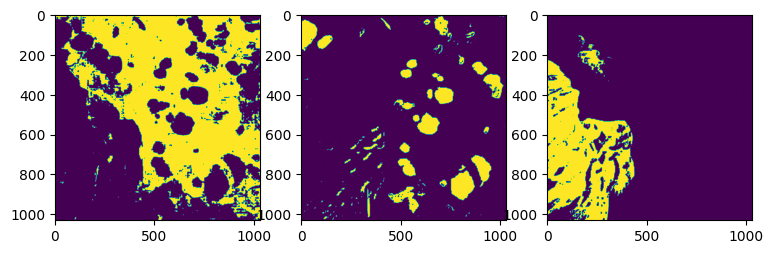

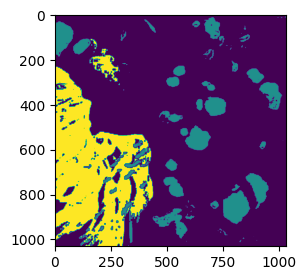

Predicted mask saved at: /content/datasets/predicted_masks/17001738902.png
Quadrat Id in progress:  17001739002


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[126, 68], [235, 185], [180, 83], [747, 54], [828, 137], [109, 252], [344, 370], [330, 351], [275, 304], [448, 319], [427, 280], [570, 418], [534, 248], [785, 321], [879, 258], [866, 332], [887, 377], [62, 605], [105, 598], [70, 430], [384, 574], [260, 539], [682, 553], [675, 445], [934, 528], [829, 577], [835, 456], [828, 433], [204, 794], [333, 741], [338, 722], [562, 660], [483, 650], [500, 716], [701, 630], [726, 763], [739, 621], [736, 694], [213, 805], [237, 969], [251, 891], [360, 884], [514, 914], [660, 818], [768, 892], [933, 889], [956, 835], [840, 822], [955, 932], [968, 796]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

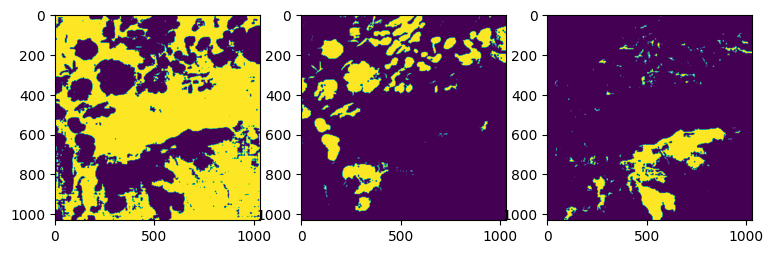

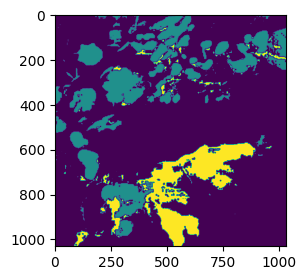

Predicted mask saved at: /content/datasets/predicted_masks/17001739002.png
Quadrat Id in progress:  17001739502


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[159, 222], [101, 105], [244, 175], [353, 139], [385, 60], [408, 141], [602, 107], [487, 192], [636, 225], [945, 201], [234, 296], [369, 367], [246, 307], [345, 283], [399, 414], [586, 371], [577, 410], [454, 305], [521, 315], [795, 398], [702, 310], [944, 378], [320, 460], [303, 556], [291, 487], [551, 426], [709, 588], [826, 594], [951, 532], [885, 528], [141, 643], [139, 717], [212, 676], [354, 728], [267, 647], [311, 642], [542, 629], [455, 632], [492, 646], [698, 769], [734, 680], [193, 801], [126, 926], [284, 842], [502, 807], [584, 957], [568, 974], [579, 958], [858, 805], [802, 879]]
DEBUG:__main__:Point Labels: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:_

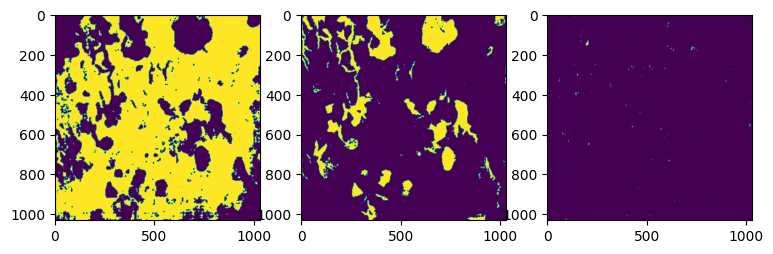

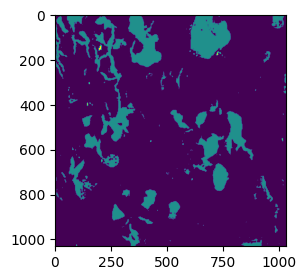

Predicted mask saved at: /content/datasets/predicted_masks/17001739502.png
Quadrat Id in progress:  17001739702


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[112, 138], [302, 205], [314, 234], [437, 138], [549, 67], [448, 222], [709, 205], [973, 99], [896, 89], [465, 243], [551, 299], [652, 399], [902, 404], [98, 505], [192, 456], [345, 463], [308, 432], [348, 479], [453, 546], [448, 516], [537, 449], [491, 541], [634, 437], [770, 601], [898, 564], [159, 780], [285, 621], [294, 725], [446, 734], [485, 710], [616, 651], [725, 690], [620, 616], [753, 647], [867, 755], [237, 973], [59, 935], [286, 853], [400, 817], [339, 960], [411, 898], [251, 928], [252, 946], [331, 833], [525, 919], [545, 878], [688, 883], [714, 831], [834, 907], [835, 869]]
DEBUG:__main__:Point Labels: [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

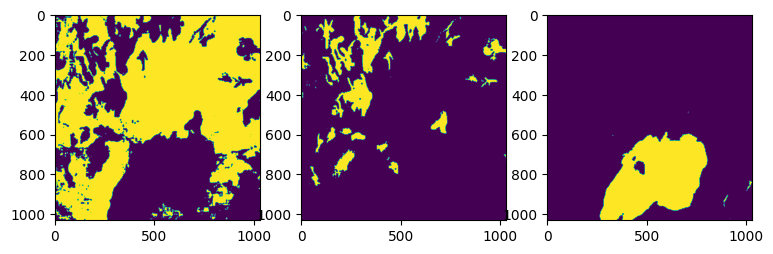

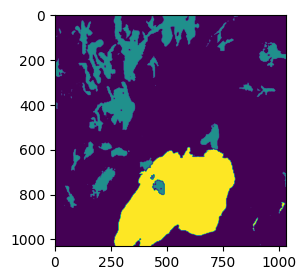

Predicted mask saved at: /content/datasets/predicted_masks/17001739702.png
Quadrat Id in progress:  17001740102


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[264, 57], [369, 80], [260, 227], [445, 193], [537, 55], [541, 207], [467, 201], [790, 52], [615, 82], [677, 117], [190, 377], [422, 266], [368, 341], [324, 395], [293, 243], [266, 327], [550, 252], [638, 243], [752, 360], [84, 508], [328, 555], [401, 601], [442, 491], [598, 464], [525, 440], [738, 565], [752, 501], [726, 508], [878, 464], [886, 445], [240, 791], [607, 612], [465, 665], [602, 781], [730, 780], [658, 654], [774, 782], [650, 731], [911, 745], [921, 665], [852, 771], [249, 959], [267, 800], [386, 961], [498, 961], [431, 855], [634, 842], [665, 907], [974, 867], [832, 801]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main

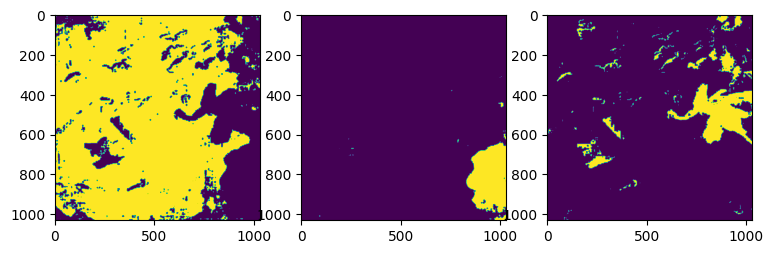

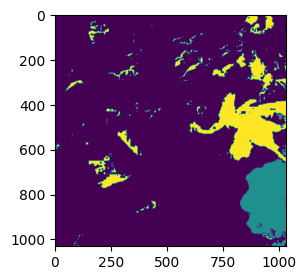

Predicted mask saved at: /content/datasets/predicted_masks/17001740102.png
Quadrat Id in progress:  17001740202


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[67, 149], [217, 180], [165, 115], [323, 205], [426, 111], [446, 213], [645, 178], [858, 231], [841, 220], [895, 136], [895, 137], [202, 390], [132, 293], [357, 402], [725, 376], [672, 412], [889, 396], [75, 501], [211, 486], [153, 549], [95, 451], [98, 468], [318, 545], [517, 544], [556, 592], [463, 462], [667, 451], [778, 577], [646, 572], [876, 576], [836, 438], [950, 555], [162, 755], [403, 655], [285, 626], [293, 629], [364, 697], [518, 618], [638, 769], [729, 774], [787, 675], [686, 714], [75, 817], [129, 950], [119, 864], [304, 956], [506, 978], [636, 932], [645, 806], [876, 895]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

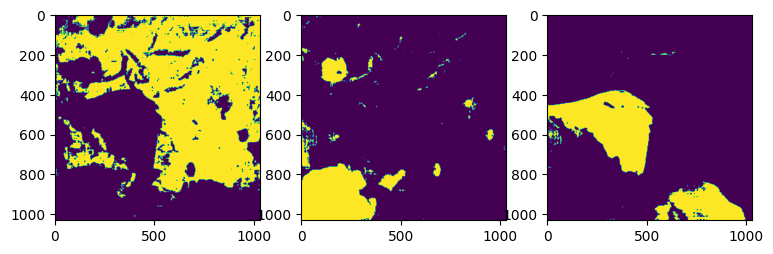

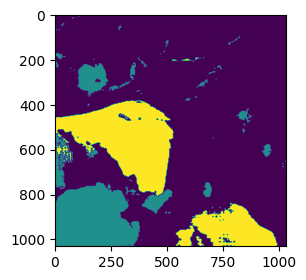

Predicted mask saved at: /content/datasets/predicted_masks/17001740202.png
Quadrat Id in progress:  17001740902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[90, 150], [112, 85], [151, 162], [226, 71], [343, 228], [322, 190], [466, 204], [481, 55], [661, 168], [727, 164], [742, 128], [818, 93], [963, 133], [911, 223], [219, 286], [192, 336], [567, 301], [448, 329], [586, 267], [756, 282], [759, 401], [720, 292], [829, 286], [805, 422], [953, 257], [53, 461], [233, 608], [243, 517], [261, 538], [338, 557], [398, 512], [609, 558], [477, 524], [667, 608], [57, 792], [129, 783], [593, 698], [565, 790], [478, 657], [736, 633], [659, 688], [900, 778], [148, 867], [62, 797], [199, 961], [354, 922], [362, 964], [933, 856], [890, 822], [943, 819]]
DEBUG:__main__:Point Labels: [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__

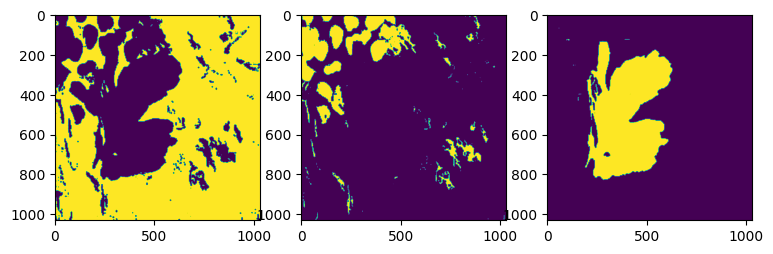

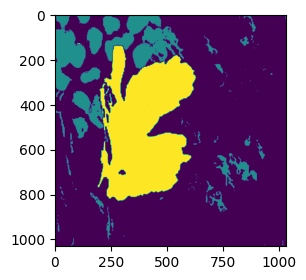

Predicted mask saved at: /content/datasets/predicted_masks/17001740902.png
Quadrat Id in progress:  17004348202


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[81, 112], [133, 193], [116, 149], [368, 111], [353, 185], [479, 123], [530, 160], [688, 143], [777, 226], [958, 218], [934, 115], [856, 90], [123, 263], [363, 355], [498, 418], [690, 238], [833, 256], [851, 323], [821, 399], [52, 480], [294, 569], [474, 559], [448, 453], [701, 435], [662, 597], [610, 427], [847, 459], [833, 497], [173, 712], [78, 690], [72, 778], [403, 699], [581, 685], [447, 740], [774, 727], [708, 625], [771, 792], [644, 750], [884, 726], [844, 634], [859, 624], [848, 620], [230, 941], [425, 946], [495, 962], [612, 816], [974, 943], [908, 975], [809, 968], [816, 853]]
DEBUG:__main__:Point Labels: [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

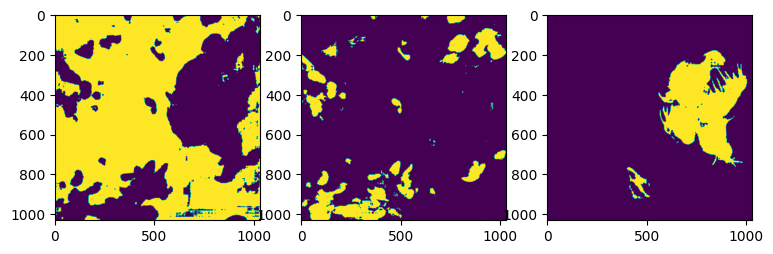

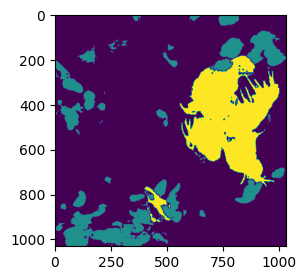

Predicted mask saved at: /content/datasets/predicted_masks/17004348202.png
Quadrat Id in progress:  17004348902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[220, 93], [158, 188], [150, 147], [265, 107], [549, 233], [763, 150], [646, 213], [781, 199], [663, 91], [95, 273], [365, 365], [250, 339], [352, 419], [418, 244], [440, 357], [540, 406], [881, 311], [846, 344], [217, 483], [97, 560], [135, 427], [416, 467], [383, 599], [531, 481], [516, 563], [435, 499], [761, 582], [657, 542], [869, 546], [954, 532], [802, 593], [864, 557], [85, 791], [146, 685], [426, 707], [484, 673], [424, 794], [574, 648], [476, 707], [447, 776], [645, 744], [882, 635], [975, 669], [814, 676], [896, 647], [192, 972], [608, 897], [503, 907], [551, 960], [614, 874]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

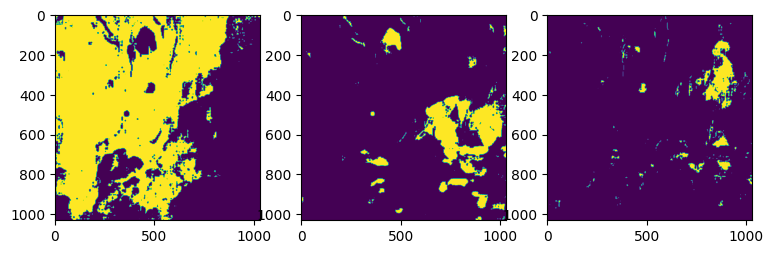

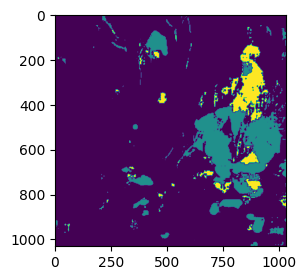

Predicted mask saved at: /content/datasets/predicted_masks/17004348902.png
Quadrat Id in progress:  17004349002


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[85, 208], [158, 56], [211, 63], [337, 131], [403, 87], [274, 74], [549, 53], [783, 128], [705, 189], [894, 92], [843, 197], [850, 93], [864, 138], [950, 93], [587, 311], [569, 272], [744, 279], [705, 389], [653, 284], [834, 356], [956, 308], [912, 366], [56, 434], [103, 561], [270, 556], [274, 428], [684, 538], [697, 434], [784, 558], [104, 758], [214, 759], [273, 717], [395, 694], [340, 793], [412, 759], [288, 701], [451, 763], [426, 614], [579, 740], [619, 622], [793, 727], [928, 627], [916, 675], [380, 850], [248, 964], [543, 965], [479, 833], [441, 846], [731, 865], [910, 958]]
DEBUG:__main__:Point Labels: [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:P

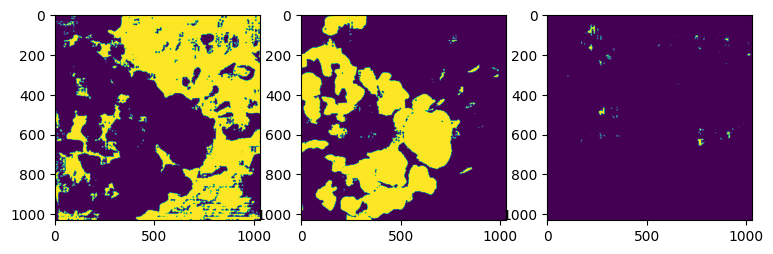

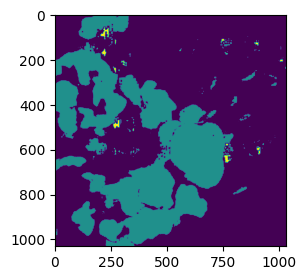

Predicted mask saved at: /content/datasets/predicted_masks/17004349002.png
Quadrat Id in progress:  17004349702


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[185, 83], [199, 154], [85, 237], [345, 230], [287, 80], [587, 81], [441, 132], [455, 122], [763, 74], [719, 62], [779, 225], [188, 401], [147, 414], [217, 302], [578, 327], [766, 291], [810, 273], [394, 447], [443, 518], [462, 497], [491, 486], [561, 545], [480, 518], [705, 446], [952, 508], [234, 688], [327, 740], [604, 669], [591, 654], [471, 757], [678, 770], [669, 677], [864, 690], [806, 641], [212, 918], [123, 857], [255, 884], [412, 819], [407, 970], [496, 823], [551, 876], [582, 908], [520, 885], [644, 895], [693, 804], [796, 977], [976, 980], [934, 807], [956, 850], [844, 914]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main

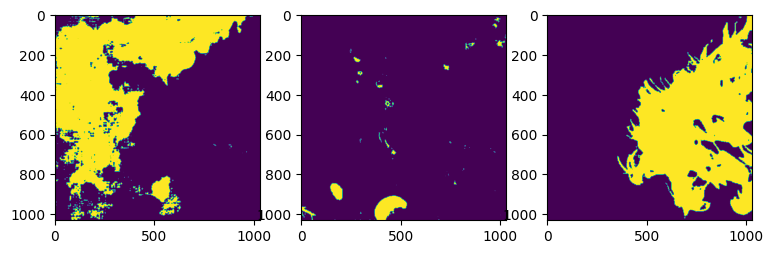

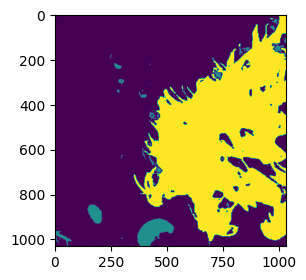

Predicted mask saved at: /content/datasets/predicted_masks/17004349702.png
Quadrat Id in progress:  17004349902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[157, 60], [210, 186], [164, 182], [162, 173], [270, 151], [288, 158], [387, 226], [520, 137], [619, 107], [721, 53], [873, 200], [908, 108], [110, 273], [335, 269], [395, 243], [425, 270], [553, 331], [739, 406], [672, 333], [635, 310], [853, 269], [808, 414], [959, 353], [801, 325], [918, 419], [216, 606], [249, 467], [417, 507], [260, 496], [546, 469], [734, 537], [874, 469], [934, 509], [191, 675], [216, 697], [364, 790], [400, 720], [254, 701], [585, 749], [743, 771], [861, 768], [820, 637], [957, 644], [119, 950], [361, 949], [563, 977], [727, 918], [640, 833], [903, 862], [913, 889]]
DEBUG:__main__:Point Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__

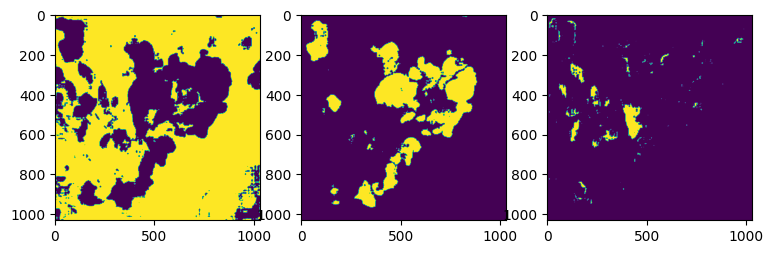

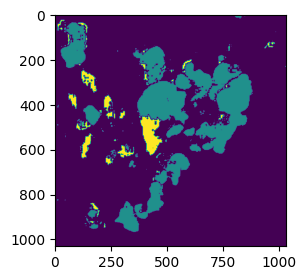

Predicted mask saved at: /content/datasets/predicted_masks/17004349902.png
Quadrat Id in progress:  17004350002


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[197, 174], [218, 143], [234, 61], [355, 152], [937, 137], [884, 106], [865, 169], [155, 289], [149, 266], [219, 327], [117, 339], [161, 412], [273, 385], [294, 372], [355, 299], [738, 389], [628, 325], [915, 276], [205, 511], [372, 476], [396, 484], [276, 482], [297, 454], [654, 435], [968, 541], [924, 460], [876, 557], [207, 717], [116, 674], [381, 638], [320, 758], [583, 747], [557, 630], [468, 733], [587, 651], [957, 696], [937, 679], [968, 652], [878, 646], [124, 932], [182, 952], [214, 980], [353, 815], [348, 922], [283, 881], [393, 954], [566, 826], [438, 937], [746, 968], [758, 883]]
DEBUG:__main__:Point Labels: [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:_

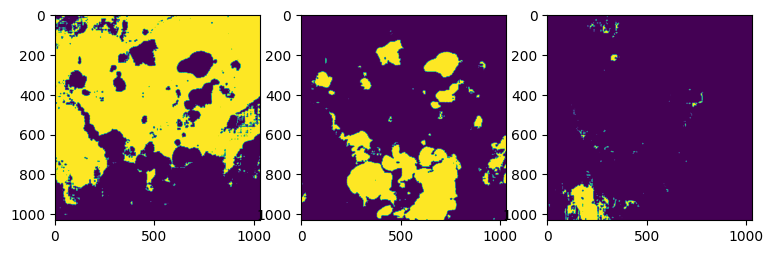

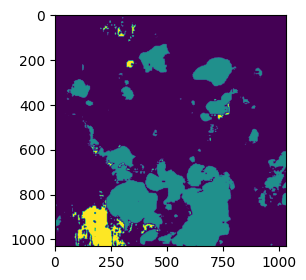

Predicted mask saved at: /content/datasets/predicted_masks/17004350002.png
Quadrat Id in progress:  17004350202


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[118, 234], [202, 198], [282, 171], [246, 61], [587, 133], [451, 153], [654, 140], [686, 213], [735, 114], [831, 65], [858, 73], [966, 86], [941, 207], [835, 75], [54, 370], [200, 344], [156, 313], [114, 294], [390, 262], [320, 327], [263, 258], [490, 331], [742, 408], [756, 356], [702, 273], [102, 524], [317, 503], [380, 575], [412, 473], [581, 603], [560, 441], [772, 519], [532, 781], [667, 629], [691, 775], [951, 654], [813, 630], [932, 736], [159, 894], [101, 969], [143, 863], [392, 888], [337, 940], [410, 840], [354, 885], [523, 962], [718, 895], [949, 942], [819, 835], [951, 812]]
DEBUG:__main__:Point Labels: [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main

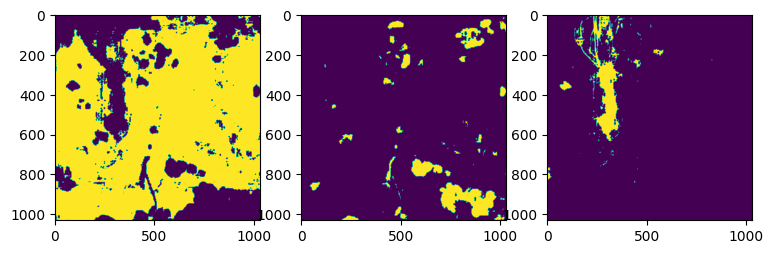

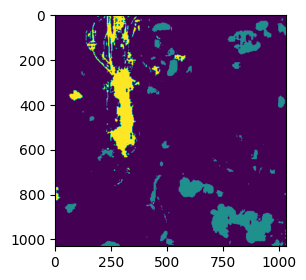

Predicted mask saved at: /content/datasets/predicted_masks/17004350202.png
Quadrat Id in progress:  17004350402


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[73, 118], [155, 101], [108, 98], [417, 193], [396, 92], [303, 215], [366, 179], [389, 112], [525, 121], [603, 221], [739, 124], [975, 142], [953, 85], [937, 181], [168, 248], [92, 416], [381, 276], [250, 390], [308, 392], [569, 410], [426, 286], [651, 380], [719, 374], [639, 371], [980, 289], [924, 280], [899, 343], [221, 497], [200, 472], [316, 436], [356, 523], [587, 534], [946, 601], [234, 714], [194, 698], [284, 769], [240, 668], [518, 649], [569, 737], [560, 611], [462, 790], [929, 730], [166, 882], [316, 833], [385, 848], [287, 876], [279, 883], [731, 971], [832, 975], [974, 918]]
DEBUG:__main__:Point Labels: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__mai

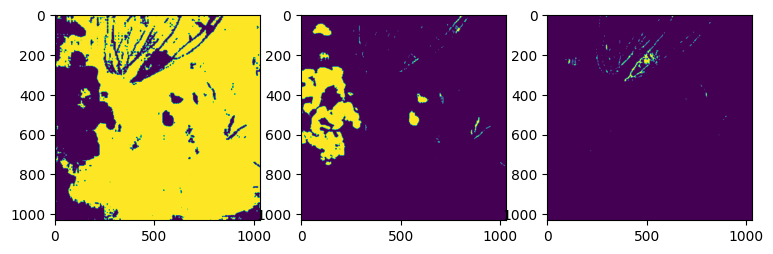

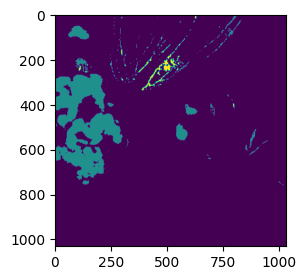

Predicted mask saved at: /content/datasets/predicted_masks/17004350402.png
Quadrat Id in progress:  17004350502


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[537, 135], [436, 111], [502, 71], [537, 73], [770, 175], [678, 155], [657, 161], [779, 149], [825, 108], [825, 114], [861, 194], [912, 161], [63, 308], [292, 404], [538, 354], [776, 376], [674, 296], [678, 325], [941, 314], [939, 254], [172, 434], [66, 603], [54, 538], [594, 511], [754, 436], [610, 548], [828, 579], [208, 761], [86, 611], [206, 698], [232, 646], [404, 665], [681, 723], [961, 769], [952, 753], [146, 914], [185, 963], [347, 815], [262, 892], [302, 845], [407, 906], [516, 928], [529, 874], [460, 975], [567, 889], [655, 821], [775, 850], [774, 939], [747, 812], [899, 953]]
DEBUG:__main__:Point Labels: [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main

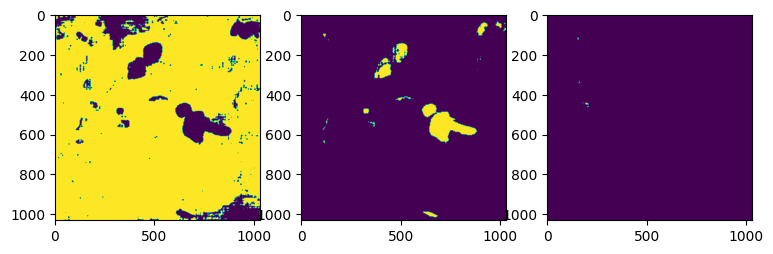

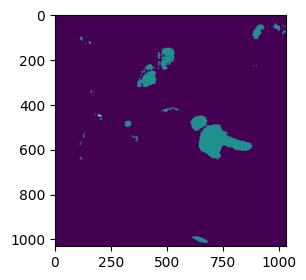

Predicted mask saved at: /content/datasets/predicted_masks/17004350502.png
Quadrat Id in progress:  17002336001


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[126, 183], [185, 188], [177, 268], [537, 291], [446, 276], [751, 182], [670, 218], [619, 114], [608, 149], [862, 288], [1225, 117], [1316, 101], [84, 452], [210, 534], [109, 458], [372, 349], [389, 520], [546, 417], [573, 477], [489, 431], [454, 370], [586, 571], [798, 485], [773, 324], [874, 546], [928, 353], [1025, 410], [975, 565], [1018, 369], [887, 435], [1009, 535], [1204, 351], [1282, 515], [240, 592], [75, 718], [231, 601], [212, 708], [312, 787], [174, 676], [271, 796], [550, 805], [363, 654], [341, 706], [773, 745], [658, 816], [608, 659], [616, 655], [741, 611], [714, 800], [658, 767], [723, 660], [728, 691], [746, 634], [881, 807], [207, 948], [167, 886], [132, 1028], [103, 1066], [133, 915], [115, 961], [514, 937], [552, 938], [650, 999], [715, 1074], [783, 839], [668, 1029], [1171, 965], [1222, 1020], [1098, 858], [1162, 1065], [1302, 1075], [1

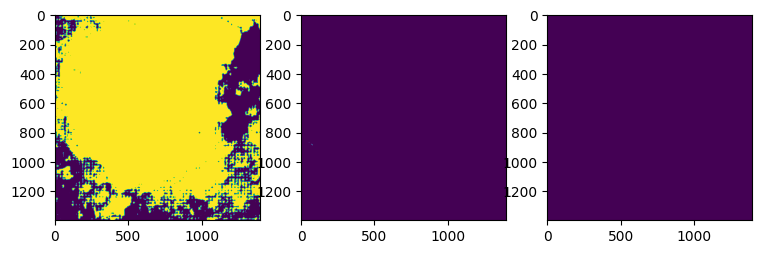

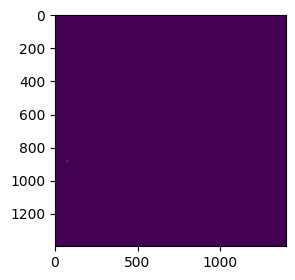

Predicted mask saved at: /content/datasets/predicted_masks/17002336001.png
Quadrat Id in progress:  20011049802


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[550, 696], [535, 700], [524, 714], [531, 734], [545, 722], [553, 740], [554, 760], [531, 763], [519, 751], [515, 733], [558, 713], [200, 583], [205, 558], [236, 700], [212, 709], [190, 724], [205, 739], [229, 729], [252, 723], [244, 791], [252, 822], [262, 806], [201, 792], [170, 798], [140, 779], [165, 771], [145, 757], [216, 777], [226, 804], [283, 800], [187, 779], [125, 768], [125, 789], [198, 694], [220, 677], [202, 669], [277, 720], [173, 700], [485, 205], [485, 176], [507, 176], [496, 156], [478, 145], [499, 129], [530, 139], [528, 161], [536, 184], [553, 167], [563, 141], [557, 120], [535, 99], [488, 108], [453, 131], [433, 132], [307, 323], [309, 343], [296, 358], [512, 145], [669, 43], [665, 18], [741, 50], [762, 43], [791, 61], [756, 69], [732, 76], [719, 67], [687, 115], [717, 128], [631, 171], [748, 27], [689, 16], [645, 56], [976, 121], [961, 9

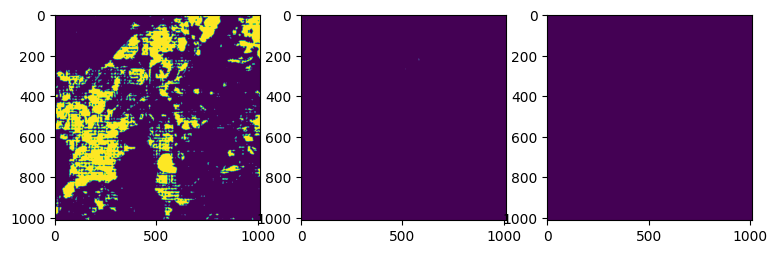

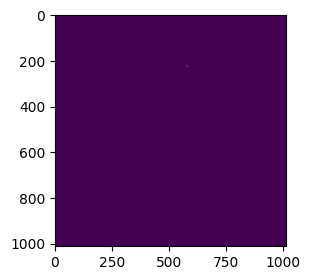

Predicted mask saved at: /content/datasets/predicted_masks/20011049802.png
Quadrat Id in progress:  20011070901


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[628, 739], [647, 748], [634, 762], [656, 773], [651, 799], [674, 796], [686, 815], [668, 831], [642, 825], [618, 833], [600, 822], [586, 798], [574, 786], [543, 798], [541, 829], [565, 814], [553, 843], [569, 857], [576, 836], [600, 851], [585, 876], [604, 876], [623, 879], [623, 860], [643, 852], [651, 882], [641, 904], [667, 898], [687, 885], [668, 869], [683, 847], [701, 831], [713, 814], [719, 858], [699, 866], [728, 888], [739, 865], [753, 838], [774, 836], [792, 848], [776, 865], [767, 890], [751, 884], [743, 917], [736, 948], [727, 983], [743, 998], [768, 975], [766, 949], [768, 923], [792, 934], [802, 911], [786, 902], [795, 874], [813, 887], [839, 898], [895, 925], [892, 946], [887, 965], [392, 825], [413, 826], [410, 800], [455, 782], [472, 771], [518, 942], [496, 942], [473, 958], [455, 981], [448, 1000], [469, 1012], [493, 1019], [493, 1037], [50

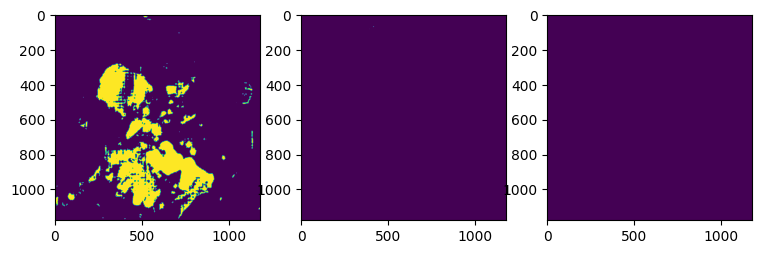

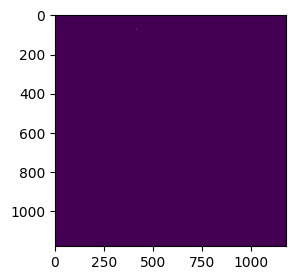

Predicted mask saved at: /content/datasets/predicted_masks/20011070901.png
Quadrat Id in progress:  20011071501


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[1176, 609], [1183, 630], [1182, 654], [1180, 670], [1166, 692], [1138, 693], [1120, 714], [1123, 738], [1102, 742], [1078, 734], [1098, 718], [1105, 696], [1119, 680], [1143, 673], [1159, 672], [1162, 649], [1156, 605], [1133, 604], [1115, 605], [1097, 616], [1085, 630], [1073, 648], [1070, 671], [1057, 690], [1064, 710], [1081, 705], [1086, 683], [1100, 665], [1124, 659], [1100, 642], [1116, 627], [1157, 630], [1137, 626], [1142, 653], [581, 875], [566, 896], [560, 918], [552, 934], [558, 954], [578, 937], [584, 910], [596, 893], [604, 871], [626, 864], [651, 873], [633, 888], [613, 891], [605, 922], [625, 910], [650, 902], [671, 889], [688, 901], [671, 916], [640, 926], [618, 936], [594, 944], [578, 959], [563, 975], [566, 999], [582, 984], [596, 969], [615, 960], [640, 949], [659, 936], [682, 937], [696, 923], [713, 940], [695, 952], [676, 963], [658, 961

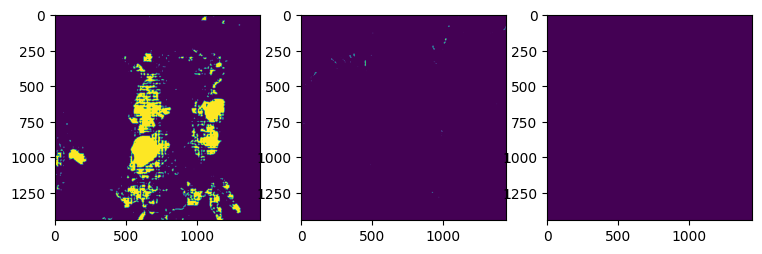

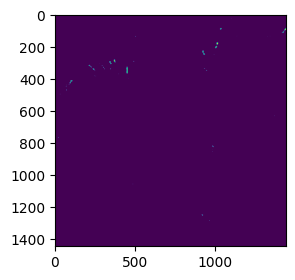

Predicted mask saved at: /content/datasets/predicted_masks/20011071501.png
Quadrat Id in progress:  20011074502


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[437, 628], [433, 602], [415, 581], [407, 620], [411, 653], [411, 692], [421, 730], [395, 751], [406, 775], [426, 761], [450, 783], [451, 750], [440, 716], [440, 686], [440, 653], [461, 653], [462, 631], [461, 598], [448, 581], [439, 559], [426, 556], [443, 530], [466, 538], [466, 564], [488, 586], [499, 570], [488, 545], [487, 520], [513, 520], [531, 503], [562, 493], [551, 538], [556, 576], [534, 553], [512, 547], [517, 584], [538, 592], [506, 611], [488, 620], [491, 657], [517, 633], [533, 646], [516, 664], [502, 695], [469, 691], [473, 724], [477, 761], [472, 801], [490, 822], [506, 837], [538, 797], [529, 827], [542, 845], [567, 840], [599, 844], [626, 844], [642, 828], [592, 823], [564, 821], [505, 805], [495, 779], [527, 773], [495, 749], [523, 736], [537, 711], [543, 672], [523, 686], [567, 697], [589, 695], [568, 740], [623, 749], [614, 773], [620, 7

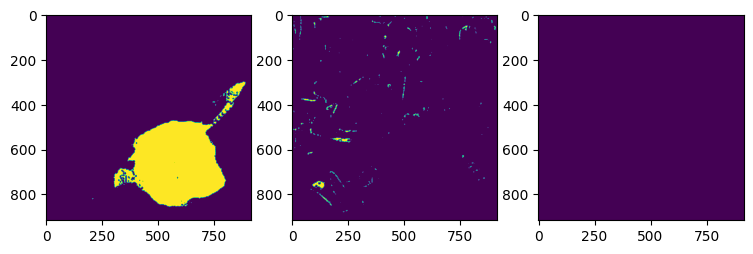

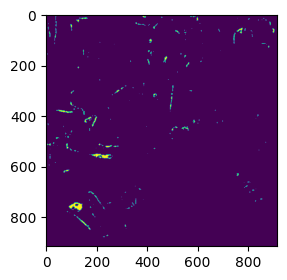

Predicted mask saved at: /content/datasets/predicted_masks/20011074502.png
Quadrat Id in progress:  17001745802


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[67, 90], [53, 205], [101, 100], [187, 236], [362, 175], [443, 194], [452, 232], [687, 68], [676, 98], [635, 207], [651, 104], [777, 219], [665, 97], [724, 116], [697, 128], [955, 235], [801, 197], [808, 118], [867, 122], [235, 260], [97, 262], [218, 368], [199, 272], [208, 415], [167, 270], [157, 413], [91, 348], [280, 251], [279, 322], [441, 275], [453, 389], [498, 378], [429, 313], [538, 274], [527, 242], [558, 256], [498, 378], [537, 400], [649, 332], [619, 381], [674, 351], [702, 333], [925, 246], [952, 303], [881, 336], [904, 265], [971, 382], [106, 433], [157, 501], [67, 475], [227, 536], [164, 451], [159, 580], [325, 509], [334, 455], [417, 515], [321, 568], [437, 444], [582, 522], [439, 438], [430, 449], [787, 489], [784, 582], [633, 462], [842, 587], [910, 477], [943, 497], [904, 594], [267, 648], [321, 737], [275, 623], [337, 623], [301, 787], [467

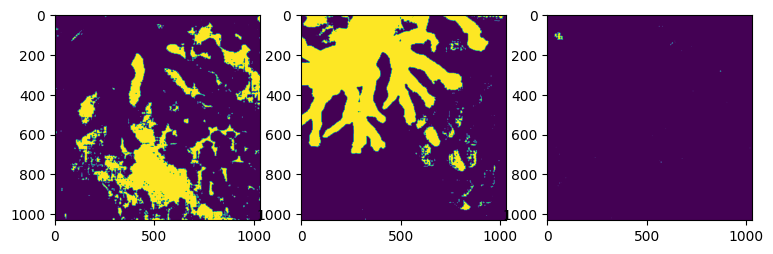

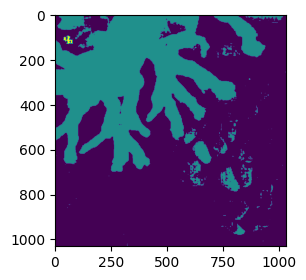

Predicted mask saved at: /content/datasets/predicted_masks/17001745802.png
Quadrat Id in progress:  17002409801


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[71, 167], [100, 277], [174, 221], [171, 319], [446, 281], [454, 183], [546, 115], [542, 253], [328, 89], [779, 223], [641, 197], [741, 131], [767, 240], [800, 136], [802, 301], [681, 304], [905, 280], [956, 205], [969, 248], [869, 154], [887, 306], [984, 261], [1196, 120], [1100, 253], [1139, 148], [1163, 252], [175, 458], [331, 500], [323, 508], [567, 491], [514, 341], [386, 504], [731, 547], [648, 540], [704, 344], [743, 350], [658, 346], [647, 437], [655, 396], [630, 537], [943, 363], [966, 461], [1059, 400], [1029, 421], [945, 415], [826, 474], [908, 402], [1100, 433], [1113, 507], [1207, 392], [1169, 418], [250, 694], [316, 745], [148, 760], [135, 727], [101, 636], [385, 769], [356, 696], [413, 683], [519, 586], [406, 793], [764, 806], [803, 679], [592, 772], [864, 785], [1003, 631], [887, 748], [914, 643], [875, 642], [1077, 656], [1119, 647], [312, 99

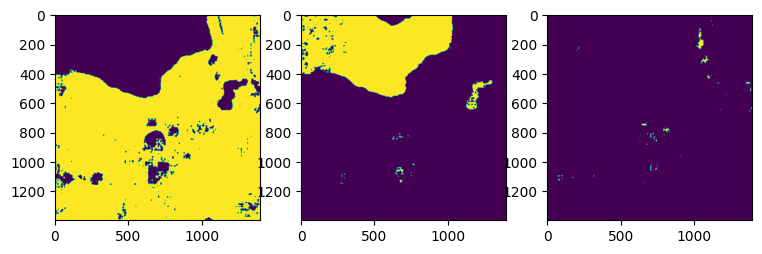

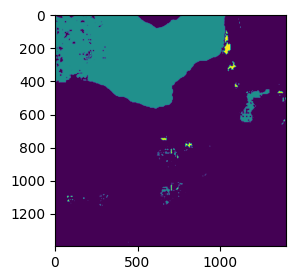

Predicted mask saved at: /content/datasets/predicted_masks/17002409801.png
Quadrat Id in progress:  17006078902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[186, 113], [121, 149], [203, 81], [220, 219], [55, 173], [112, 106], [272, 68], [353, 62], [404, 207], [324, 120], [472, 65], [609, 63], [502, 186], [484, 220], [687, 166], [695, 177], [646, 163], [678, 169], [704, 59], [744, 84], [759, 202], [790, 111], [769, 150], [778, 74], [809, 219], [825, 64], [917, 234], [163, 275], [166, 410], [86, 286], [124, 378], [326, 291], [371, 386], [247, 283], [381, 338], [296, 373], [544, 298], [477, 238], [456, 239], [585, 340], [772, 296], [725, 276], [632, 366], [722, 341], [829, 422], [876, 318], [977, 345], [892, 402], [890, 281], [103, 468], [122, 455], [221, 487], [148, 552], [66, 561], [131, 590], [285, 499], [300, 599], [252, 455], [305, 567], [269, 522], [364, 596], [541, 513], [522, 594], [760, 591], [771, 513], [652, 502], [782, 547], [878, 574], [820, 472], [143, 630], [57, 689], [110, 773], [320, 654], [380, 65

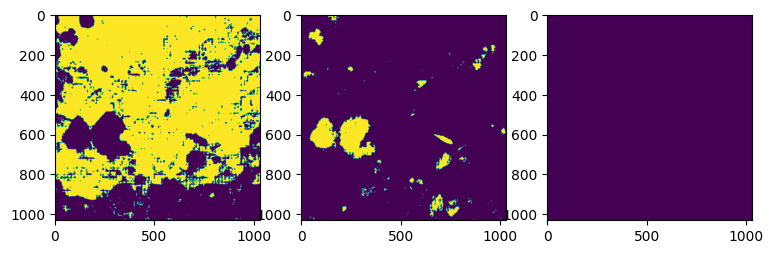

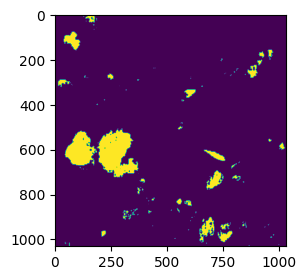

Predicted mask saved at: /content/datasets/predicted_masks/17006078902.png
Quadrat Id in progress:  17019870602


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[221, 88], [217, 158], [156, 228], [131, 128], [276, 189], [243, 215], [405, 146], [536, 124], [595, 87], [750, 77], [765, 108], [756, 151], [919, 178], [922, 173], [876, 234], [114, 284], [198, 260], [225, 353], [119, 298], [109, 371], [203, 275], [135, 271], [285, 387], [307, 271], [415, 250], [239, 380], [316, 300], [351, 304], [433, 313], [460, 386], [437, 362], [507, 259], [514, 355], [437, 266], [778, 384], [617, 270], [951, 267], [828, 363], [220, 471], [197, 557], [230, 464], [210, 473], [132, 567], [412, 579], [419, 478], [303, 578], [247, 446], [596, 528], [454, 453], [626, 458], [758, 462], [763, 503], [749, 459], [731, 547], [762, 559], [836, 560], [890, 470], [80, 778], [57, 760], [68, 612], [368, 681], [264, 683], [246, 739], [268, 651], [340, 663], [285, 778], [498, 761], [497, 742], [444, 750], [744, 636], [692, 733], [946, 653], [804, 670], [

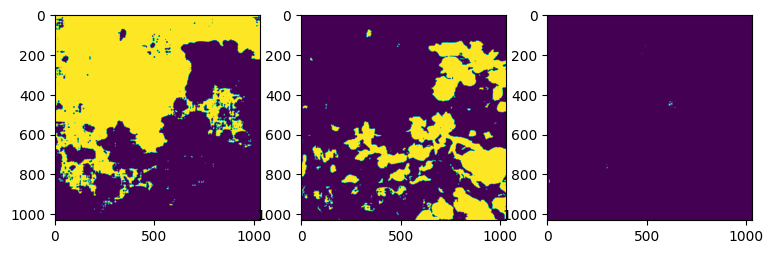

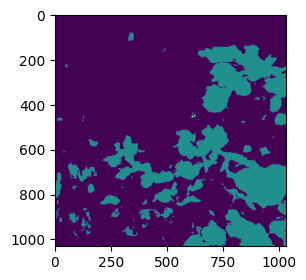

Predicted mask saved at: /content/datasets/predicted_masks/17019870602.png
Quadrat Id in progress:  17019871102


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[219, 149], [111, 104], [237, 64], [187, 68], [297, 204], [338, 106], [346, 98], [297, 129], [295, 127], [329, 160], [346, 98], [361, 161], [565, 85], [539, 139], [462, 217], [467, 145], [595, 104], [600, 96], [459, 130], [530, 151], [428, 206], [712, 174], [733, 82], [744, 124], [943, 166], [974, 142], [907, 229], [134, 283], [154, 242], [323, 396], [248, 389], [524, 416], [489, 348], [487, 406], [489, 297], [748, 331], [719, 263], [762, 313], [883, 350], [908, 335], [195, 459], [172, 597], [177, 481], [163, 446], [198, 456], [52, 446], [112, 517], [357, 476], [443, 534], [432, 537], [595, 583], [711, 574], [622, 496], [610, 437], [783, 455], [724, 491], [642, 451], [763, 481], [670, 453], [930, 561], [940, 450], [915, 589], [870, 430], [199, 622], [71, 794], [313, 777], [263, 629], [377, 640], [581, 622], [549, 731], [520, 616], [568, 693], [790, 759], [980

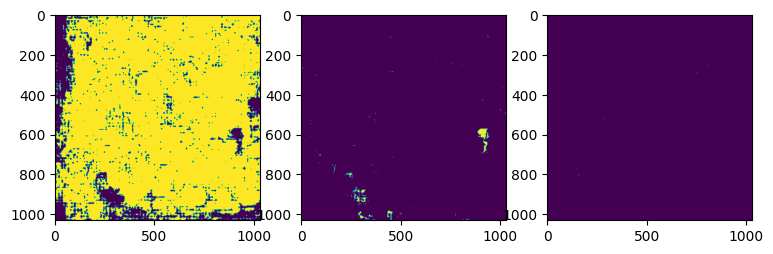

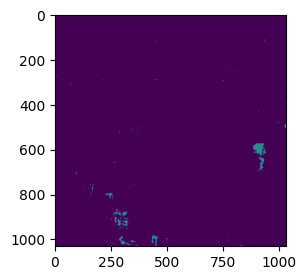

Predicted mask saved at: /content/datasets/predicted_masks/17019871102.png
Quadrat Id in progress:  17001652802


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[97, 204], [136, 85], [188, 162], [55, 172], [127, 170], [91, 225], [242, 228], [386, 219], [346, 197], [453, 92], [438, 129], [497, 153], [504, 61], [736, 205], [623, 80], [633, 114], [743, 165], [914, 196], [912, 118], [923, 143], [907, 165], [878, 141], [882, 145], [204, 378], [78, 400], [133, 281], [136, 413], [155, 385], [217, 323], [605, 287], [597, 353], [603, 370], [586, 267], [524, 299], [703, 325], [721, 318], [679, 366], [713, 415], [654, 342], [952, 365], [797, 266], [970, 326], [979, 282], [928, 304], [872, 396], [890, 291], [834, 364], [76, 451], [217, 568], [113, 576], [328, 577], [354, 433], [465, 473], [540, 562], [598, 477], [705, 559], [648, 596], [674, 505], [654, 544], [776, 464], [959, 564], [874, 479], [63, 685], [214, 701], [217, 759], [62, 640], [353, 658], [358, 614], [415, 631], [265, 685], [309, 746], [285, 790], [414, 738], [448, 

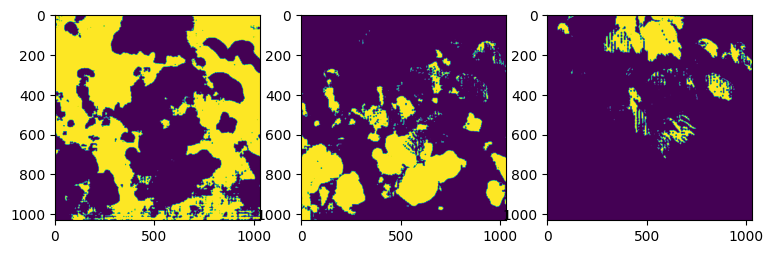

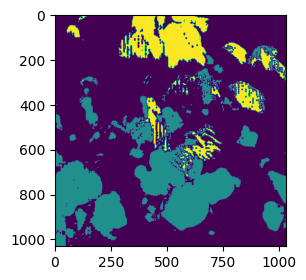

Predicted mask saved at: /content/datasets/predicted_masks/17001652802.png
Quadrat Id in progress:  17004426901


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[75, 200], [144, 164], [53, 52], [394, 109], [401, 231], [395, 145], [587, 74], [451, 81], [606, 95], [533, 209], [498, 125], [498, 179], [678, 221], [707, 188], [638, 224], [664, 226], [698, 184], [952, 213], [917, 237], [975, 85], [939, 70], [831, 89], [903, 146], [829, 80], [164, 244], [70, 242], [149, 389], [215, 315], [397, 414], [381, 292], [299, 412], [510, 403], [563, 407], [427, 417], [598, 247], [577, 420], [583, 315], [601, 327], [525, 423], [458, 247], [784, 346], [752, 259], [716, 395], [636, 398], [902, 312], [897, 281], [852, 337], [807, 389], [846, 310], [73, 563], [155, 559], [229, 519], [94, 547], [411, 472], [370, 556], [367, 525], [300, 484], [515, 590], [477, 475], [535, 458], [648, 441], [769, 441], [617, 476], [762, 545], [716, 439], [907, 512], [188, 646], [162, 626], [52, 653], [345, 684], [330, 672], [298, 685], [417, 782], [501, 788

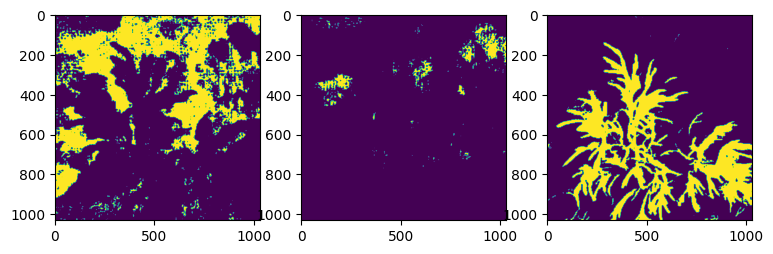

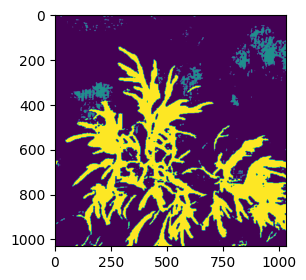

Predicted mask saved at: /content/datasets/predicted_masks/17004426901.png
Quadrat Id in progress:  17005029401


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[197, 92], [172, 123], [290, 277], [276, 320], [218, 199], [330, 254], [545, 138], [447, 156], [545, 129], [542, 250], [717, 169], [576, 258], [585, 267], [795, 103], [638, 131], [841, 263], [970, 107], [835, 249], [1109, 199], [1096, 187], [1157, 155], [1146, 199], [1248, 174], [193, 389], [199, 501], [219, 521], [178, 544], [128, 556], [476, 554], [521, 324], [325, 514], [330, 445], [406, 570], [825, 470], [696, 361], [711, 572], [798, 541], [626, 325], [606, 394], [980, 333], [1057, 466], [835, 459], [1319, 432], [1238, 469], [206, 629], [209, 657], [120, 577], [208, 632], [428, 722], [438, 752], [437, 726], [331, 726], [794, 749], [679, 705], [810, 713], [646, 679], [810, 595], [1060, 594], [922, 806], [1151, 670], [1201, 598], [1172, 616], [1313, 801], [290, 841], [256, 993], [74, 843], [178, 840], [338, 1050], [365, 984], [394, 1019], [424, 887], [722, 

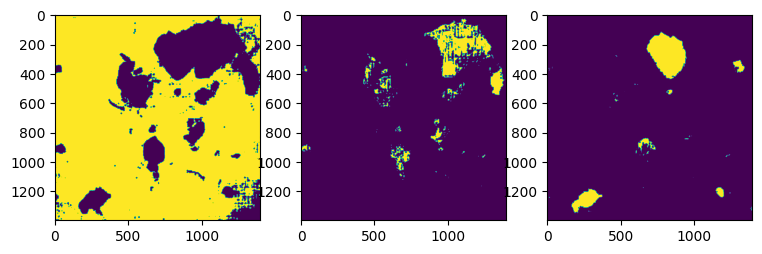

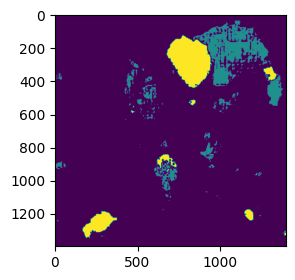

Predicted mask saved at: /content/datasets/predicted_masks/17005029401.png
Quadrat Id in progress:  17006058202


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[217, 198], [78, 230], [64, 198], [224, 177], [61, 159], [52, 188], [411, 185], [409, 188], [425, 160], [442, 130], [428, 218], [688, 211], [709, 90], [774, 224], [632, 147], [865, 174], [959, 163], [912, 224], [869, 209], [851, 103], [826, 75], [856, 193], [183, 270], [170, 298], [150, 389], [344, 294], [391, 305], [485, 263], [642, 353], [787, 368], [893, 272], [924, 272], [812, 421], [966, 301], [886, 267], [101, 426], [207, 575], [186, 526], [205, 464], [233, 600], [208, 480], [284, 488], [410, 507], [382, 503], [296, 434], [451, 460], [482, 450], [436, 589], [746, 579], [794, 519], [641, 439], [714, 517], [656, 565], [695, 474], [727, 558], [847, 588], [823, 544], [183, 772], [110, 622], [71, 770], [297, 760], [352, 777], [403, 776], [354, 729], [592, 615], [516, 768], [555, 788], [524, 739], [608, 669], [654, 741], [688, 684], [638, 692], [649, 753], [7

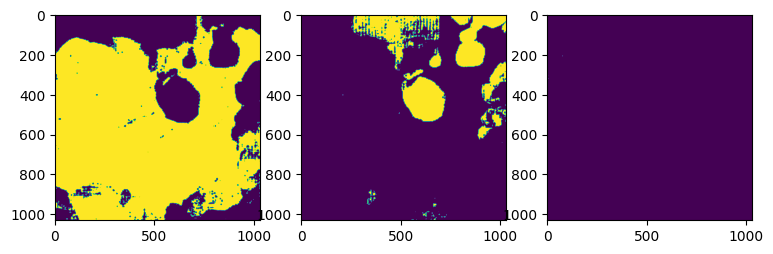

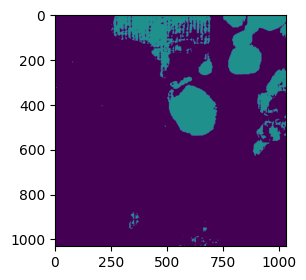

Predicted mask saved at: /content/datasets/predicted_masks/17006058202.png
Quadrat Id in progress:  17006100402


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[106, 56], [180, 79], [170, 133], [224, 190], [219, 137], [272, 144], [392, 209], [298, 174], [259, 166], [452, 225], [470, 91], [599, 194], [510, 198], [943, 231], [806, 79], [869, 171], [925, 195], [804, 220], [69, 240], [59, 362], [177, 287], [78, 399], [346, 401], [344, 320], [273, 303], [325, 340], [243, 377], [499, 344], [555, 319], [579, 334], [571, 420], [654, 323], [634, 404], [653, 245], [687, 294], [849, 395], [857, 269], [157, 504], [278, 474], [377, 506], [405, 426], [307, 481], [335, 578], [478, 427], [585, 470], [556, 599], [442, 538], [435, 542], [456, 580], [553, 480], [473, 550], [942, 496], [800, 516], [835, 559], [866, 576], [868, 582], [861, 525], [205, 756], [186, 737], [124, 615], [101, 726], [103, 619], [71, 762], [91, 722], [291, 680], [340, 745], [414, 671], [378, 639], [361, 679], [573, 679], [539, 660], [527, 699], [606, 615], [691

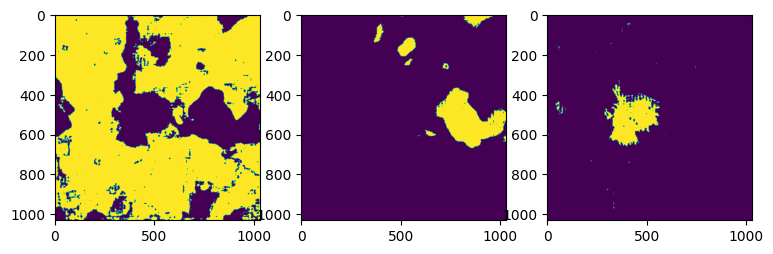

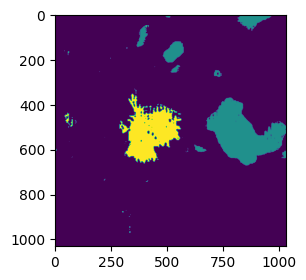

Predicted mask saved at: /content/datasets/predicted_masks/17006100402.png
Quadrat Id in progress:  17007661501


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[224, 254], [203, 92], [152, 149], [565, 264], [350, 212], [773, 246], [814, 189], [646, 113], [654, 130], [681, 116], [943, 302], [869, 146], [1015, 166], [913, 223], [1254, 140], [1103, 101], [1215, 292], [1322, 185], [260, 471], [309, 558], [346, 555], [509, 554], [555, 391], [563, 568], [496, 548], [452, 552], [478, 527], [492, 339], [809, 427], [679, 537], [764, 379], [736, 481], [644, 569], [795, 364], [855, 396], [826, 530], [1000, 374], [827, 510], [1282, 509], [1204, 427], [1149, 358], [97, 675], [309, 635], [180, 811], [100, 771], [255, 615], [339, 803], [552, 655], [446, 700], [405, 669], [631, 690], [668, 740], [645, 680], [638, 782], [718, 722], [792, 578], [961, 688], [1007, 679], [958, 769], [850, 820], [1297, 798], [1152, 650], [211, 1022], [237, 883], [217, 830], [155, 1042], [326, 924], [334, 1043], [369, 1070], [361, 904], [625, 1042], [764

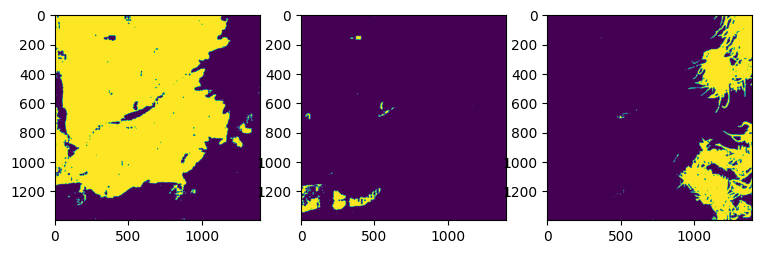

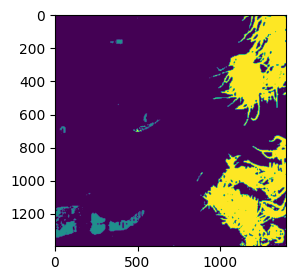

Predicted mask saved at: /content/datasets/predicted_masks/17007661501.png
Quadrat Id in progress:  17017815902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[74, 209], [234, 179], [93, 54], [218, 201], [407, 115], [400, 194], [322, 112], [344, 181], [491, 181], [503, 200], [950, 219], [860, 170], [885, 204], [841, 113], [859, 72], [162, 326], [236, 268], [146, 309], [373, 419], [345, 402], [301, 368], [370, 315], [413, 300], [325, 423], [503, 280], [482, 323], [548, 240], [428, 252], [445, 260], [539, 384], [745, 359], [636, 379], [641, 354], [679, 318], [635, 357], [738, 298], [636, 416], [703, 407], [797, 332], [926, 314], [832, 368], [817, 298], [185, 501], [126, 608], [389, 454], [316, 485], [407, 463], [283, 556], [245, 461], [378, 504], [456, 590], [682, 595], [791, 427], [669, 543], [640, 498], [793, 520], [696, 534], [642, 550], [878, 582], [816, 482], [966, 492], [971, 485], [137, 774], [183, 760], [105, 674], [140, 703], [174, 675], [286, 621], [353, 740], [371, 670], [601, 712], [523, 756], [772, 766],

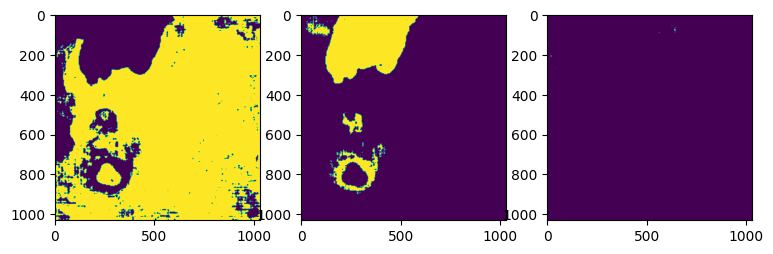

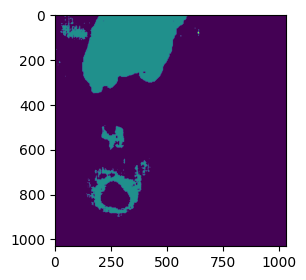

Predicted mask saved at: /content/datasets/predicted_masks/17017815902.png
Quadrat Id in progress:  17019937902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[127, 124], [81, 207], [72, 224], [164, 83], [121, 182], [172, 197], [226, 69], [305, 86], [409, 224], [259, 215], [455, 149], [444, 186], [437, 131], [636, 93], [623, 171], [792, 174], [642, 104], [639, 80], [634, 66], [643, 104], [785, 109], [813, 160], [820, 104], [934, 84], [188, 362], [90, 252], [109, 286], [316, 406], [338, 266], [367, 294], [263, 410], [535, 358], [444, 375], [619, 306], [779, 387], [750, 363], [935, 413], [931, 273], [924, 342], [185, 528], [87, 536], [247, 467], [329, 588], [352, 496], [314, 447], [423, 567], [338, 538], [283, 467], [360, 515], [510, 454], [433, 543], [472, 450], [437, 465], [661, 582], [782, 594], [747, 465], [629, 455], [866, 513], [901, 574], [796, 450], [977, 552], [884, 565], [942, 597], [74, 772], [184, 709], [334, 688], [528, 611], [451, 770], [586, 683], [503, 714], [737, 772], [741, 707], [788, 655], [786, 7

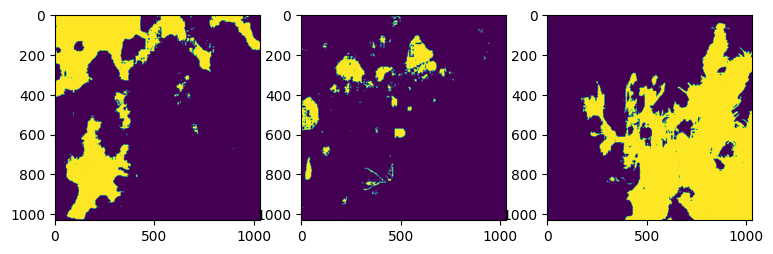

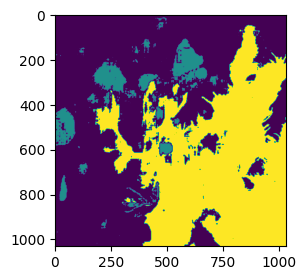

Predicted mask saved at: /content/datasets/predicted_masks/17019937902.png
Quadrat Id in progress:  17024674002


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[159, 116], [178, 112], [126, 69], [280, 112], [242, 109], [279, 71], [300, 155], [386, 108], [251, 160], [350, 73], [466, 176], [621, 202], [675, 194], [663, 159], [653, 104], [795, 198], [821, 138], [918, 91], [922, 110], [206, 320], [205, 398], [142, 395], [197, 308], [141, 356], [94, 334], [331, 390], [401, 241], [535, 399], [517, 249], [496, 313], [485, 273], [514, 256], [607, 264], [693, 266], [767, 394], [960, 353], [930, 423], [840, 363], [207, 444], [152, 570], [64, 430], [400, 598], [380, 585], [411, 521], [396, 485], [307, 430], [543, 459], [445, 592], [652, 467], [790, 527], [764, 454], [702, 595], [796, 439], [896, 424], [882, 564], [931, 475], [843, 560], [197, 648], [191, 697], [153, 635], [169, 639], [230, 697], [107, 773], [103, 671], [115, 735], [339, 647], [316, 710], [341, 634], [523, 703], [547, 792], [788, 754], [674, 753], [793, 656], [

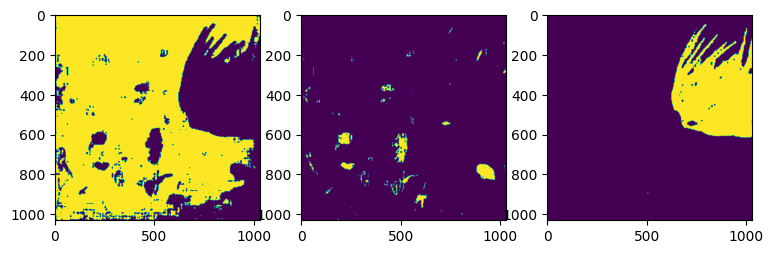

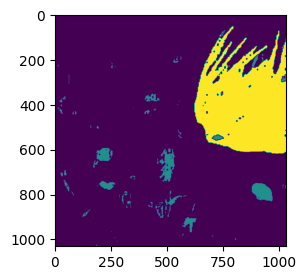

Predicted mask saved at: /content/datasets/predicted_masks/17024674002.png
Quadrat Id in progress:  17039196602


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[95, 102], [310, 235], [368, 129], [338, 57], [255, 156], [307, 190], [482, 212], [463, 58], [551, 231], [686, 58], [680, 220], [714, 175], [743, 137], [712, 179], [693, 65], [790, 227], [882, 179], [849, 85], [211, 242], [222, 356], [125, 359], [254, 359], [558, 317], [470, 371], [464, 266], [590, 249], [593, 358], [777, 330], [690, 333], [773, 422], [616, 307], [910, 378], [800, 372], [890, 279], [881, 352], [202, 568], [127, 525], [157, 460], [268, 482], [333, 609], [345, 534], [345, 532], [409, 439], [583, 565], [553, 451], [507, 552], [464, 504], [602, 458], [620, 517], [620, 471], [757, 518], [749, 506], [761, 582], [650, 460], [811, 595], [833, 537], [926, 553], [819, 570], [933, 506], [228, 664], [128, 679], [54, 634], [269, 682], [245, 748], [384, 714], [266, 649], [255, 669], [546, 640], [448, 763], [462, 641], [430, 707], [507, 733], [469, 782], [4

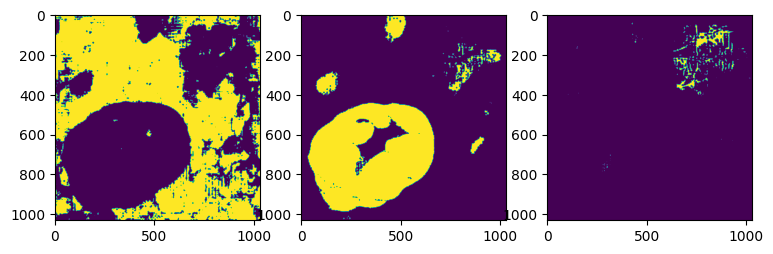

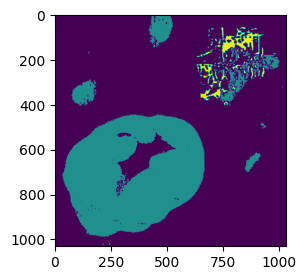

Predicted mask saved at: /content/datasets/predicted_masks/17039196602.png
Quadrat Id in progress:  20011030301


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[321, 1147], [321, 1103], [325, 1054], [327, 1020], [363, 1038], [377, 1163], [229, 1189], [182, 1167], [184, 1123], [136, 1111], [100, 1119], [134, 1075], [108, 1030], [160, 1101], [106, 1261], [70, 749], [98, 723], [122, 667], [142, 701], [176, 679], [206, 717], [654, 611], [681, 633], [719, 673], [782, 670], [789, 640], [790, 617], [1029, 1253], [1085, 1247], [1120, 1180], [1135, 1213], [1133, 1257], [1118, 1284], [1105, 1313], [1185, 1298], [1196, 1274], [1214, 1226], [1174, 1340], [1037, 1286], [1079, 1339], [968, 864], [264, 648], [287, 599], [288, 558], [248, 596], [230, 656], [200, 642], [220, 574], [251, 562], [174, 475], [188, 508], [204, 542], [194, 569], [169, 585], [130, 599], [159, 643], [175, 615], [240, 626], [279, 622], [175, 542], [440, 349], [470, 329], [416, 314], [344, 315], [382, 269], [310, 257], [308, 353], [435, 378], [263, 242], [445

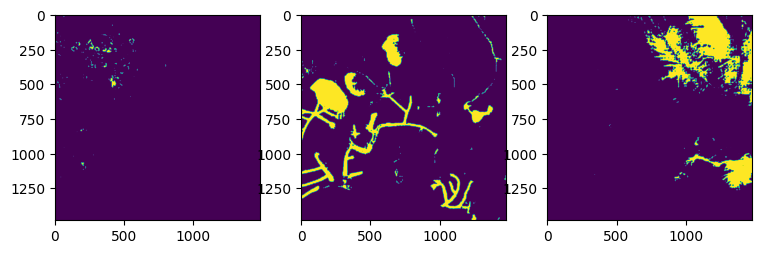

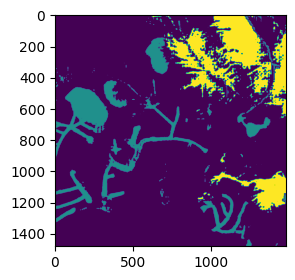

Predicted mask saved at: /content/datasets/predicted_masks/20011030301.png
Quadrat Id in progress:  20015204202


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[652, 682], [637, 698], [643, 709], [629, 718], [620, 703], [602, 706], [610, 722], [603, 737], [592, 720], [580, 737], [588, 751], [580, 765], [571, 780], [559, 772], [562, 751], [547, 787], [535, 771], [523, 789], [515, 805], [492, 810], [503, 792], [481, 798], [468, 808], [462, 824], [439, 825], [424, 821], [410, 828], [385, 831], [108, 128], [109, 146], [101, 165], [98, 274], [84, 271], [101, 409], [89, 427], [107, 438], [113, 422], [265, 203], [183, 230], [102, 548], [107, 570], [112, 591], [128, 571], [125, 554], [606, 760], [615, 775], [629, 783], [307, 392], [64, 497], [683, 630], [701, 665], [715, 690], [740, 706], [759, 727], [799, 704], [801, 687], [757, 687], [742, 664], [713, 627], [754, 616], [785, 622], [826, 628], [834, 616], [787, 575], [805, 560], [820, 525], [844, 501], [837, 480], [824, 504], [840, 532], [823, 551], [809, 620], [831, 696],

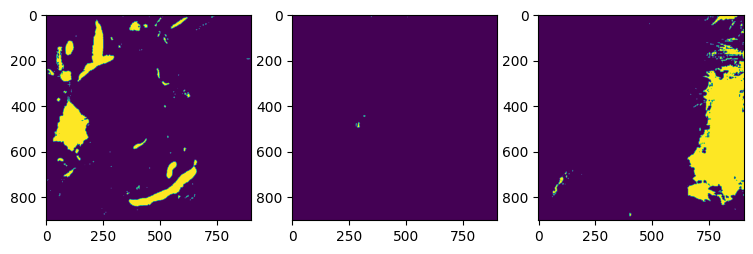

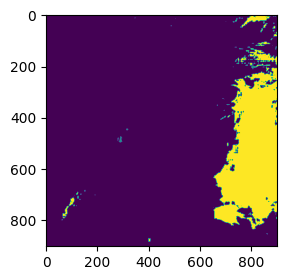

Predicted mask saved at: /content/datasets/predicted_masks/20015204202.png
Quadrat Id in progress:  20020045901


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[730, 829], [743, 817], [746, 801], [754, 788], [766, 774], [796, 776], [822, 842], [1178, 333], [1181, 346], [1189, 367], [1206, 372], [1210, 358], [1196, 341], [1216, 341], [1100, 339], [1080, 323], [1064, 305], [1045, 305], [1041, 330], [1054, 345], [1076, 343], [1057, 325], [1085, 314], [1100, 318], [249, 559], [260, 549], [276, 553], [292, 555], [308, 557], [275, 612], [288, 655], [347, 671], [348, 655], [444, 603], [446, 624], [436, 588], [461, 600], [477, 584], [486, 596], [450, 786], [428, 778], [409, 776], [1134, 261], [1134, 278], [595, 414], [601, 382], [562, 408], [522, 416], [504, 403], [474, 386], [448, 386], [478, 416], [524, 443], [557, 462], [606, 446], [625, 418], [639, 396], [607, 360], [578, 368], [547, 391], [654, 372], [585, 422], [578, 447], [641, 435], [657, 404], [517, 471], [502, 444], [500, 428], [496, 384], [458, 367], [413, 383], 

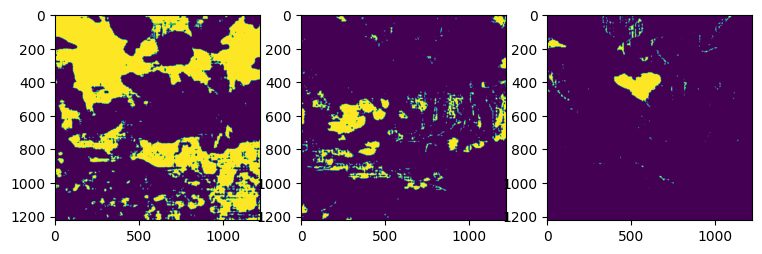

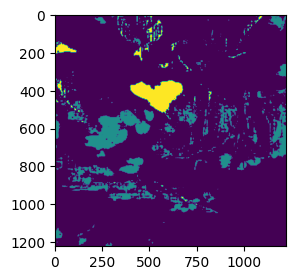

Predicted mask saved at: /content/datasets/predicted_masks/20020045901.png
Quadrat Id in progress:  20024036902


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[124, 180], [214, 79], [70, 149], [203, 117], [235, 140], [365, 133], [396, 167], [503, 66], [421, 131], [645, 124], [581, 98], [611, 175], [626, 118], [604, 204], [656, 205], [881, 67], [887, 61], [838, 177], [858, 138], [884, 186], [777, 167], [765, 103], [794, 155], [886, 63], [206, 251], [57, 361], [176, 350], [92, 377], [67, 257], [252, 217], [325, 287], [410, 312], [500, 290], [591, 358], [702, 269], [580, 290], [624, 338], [607, 219], [586, 253], [698, 250], [782, 300], [870, 246], [826, 230], [796, 310], [729, 217], [867, 326], [756, 325], [147, 490], [114, 452], [364, 461], [358, 401], [495, 521], [413, 530], [414, 412], [522, 439], [682, 499], [703, 392], [842, 528], [812, 553], [786, 529], [786, 441], [54, 627], [76, 630], [61, 602], [284, 687], [364, 581], [359, 560], [538, 574], [509, 605], [544, 667], [419, 601], [474, 691], [645, 644], [593, 67

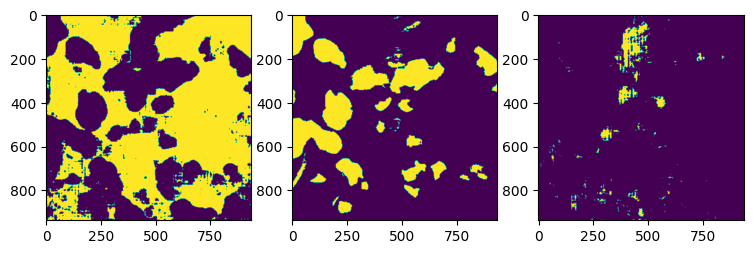

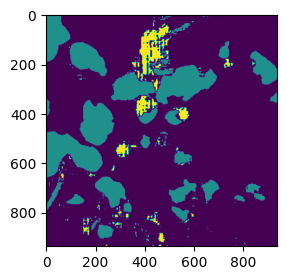

Predicted mask saved at: /content/datasets/predicted_masks/20024036902.png
Quadrat Id in progress:  20024058602


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[222, 175], [215, 144], [69, 115], [395, 162], [306, 204], [341, 73], [243, 135], [293, 120], [318, 153], [508, 97], [546, 99], [412, 65], [444, 190], [566, 98], [681, 100], [694, 178], [891, 51], [801, 202], [881, 176], [74, 260], [125, 370], [188, 288], [285, 251], [296, 304], [329, 387], [380, 247], [406, 306], [354, 366], [384, 365], [348, 298], [512, 352], [449, 286], [560, 387], [432, 282], [528, 276], [535, 391], [625, 263], [670, 346], [713, 392], [597, 342], [688, 365], [778, 360], [875, 315], [777, 242], [860, 248], [824, 308], [887, 281], [219, 484], [224, 467], [369, 464], [368, 439], [453, 472], [569, 515], [433, 466], [661, 454], [721, 540], [626, 527], [817, 493], [860, 526], [804, 417], [823, 469], [805, 545], [796, 581], [70, 750], [94, 623], [287, 648], [313, 660], [287, 616], [392, 716], [253, 701], [558, 643], [446, 760], [571, 634], [447,

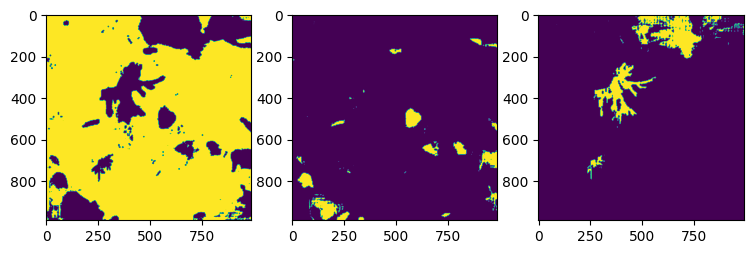

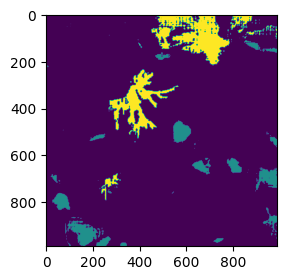

Predicted mask saved at: /content/datasets/predicted_masks/20024058602.png
Quadrat Id in progress:  20024071502


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[169, 66], [189, 129], [184, 63], [367, 97], [232, 210], [422, 83], [577, 156], [829, 123], [771, 145], [64, 276], [152, 314], [79, 285], [69, 295], [79, 234], [514, 371], [432, 269], [409, 290], [401, 351], [476, 230], [524, 234], [392, 270], [465, 331], [624, 288], [668, 316], [558, 284], [702, 276], [563, 281], [836, 250], [203, 502], [78, 405], [111, 539], [131, 472], [109, 541], [114, 437], [177, 383], [230, 539], [269, 388], [222, 495], [279, 456], [215, 481], [464, 542], [510, 474], [641, 476], [696, 545], [684, 448], [689, 538], [567, 461], [685, 475], [588, 418], [787, 547], [828, 443], [803, 499], [803, 487], [785, 417], [829, 499], [741, 513], [810, 394], [874, 544], [73, 645], [107, 555], [171, 580], [186, 685], [336, 655], [331, 704], [366, 626], [333, 549], [246, 584], [224, 603], [495, 571], [399, 634], [507, 565], [591, 576], [660, 672], [772,

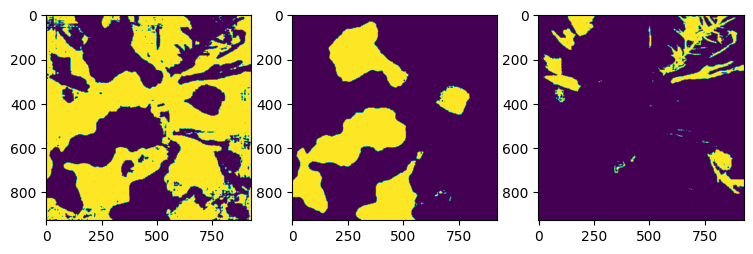

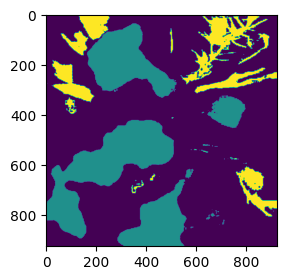

Predicted mask saved at: /content/datasets/predicted_masks/20024071502.png
Quadrat Id in progress:  20028206201


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[154, 195], [74, 209], [110, 189], [172, 232], [82, 220], [185, 63], [89, 205], [390, 213], [378, 77], [236, 120], [412, 105], [421, 170], [443, 112], [637, 159], [673, 60], [912, 145], [822, 114], [791, 71], [778, 193], [190, 382], [105, 324], [71, 362], [240, 237], [372, 293], [316, 285], [354, 251], [298, 290], [491, 402], [487, 366], [489, 386], [439, 374], [481, 402], [767, 407], [633, 277], [714, 323], [744, 364], [729, 255], [756, 244], [915, 306], [192, 432], [102, 418], [183, 515], [167, 506], [313, 448], [478, 510], [511, 577], [582, 506], [562, 478], [432, 571], [501, 540], [660, 504], [757, 490], [756, 536], [755, 519], [699, 506], [748, 561], [923, 586], [831, 557], [880, 476], [66, 685], [210, 708], [115, 731], [66, 705], [154, 716], [395, 677], [257, 607], [371, 730], [378, 609], [462, 601], [541, 757], [482, 685], [502, 604], [428, 646], [738,

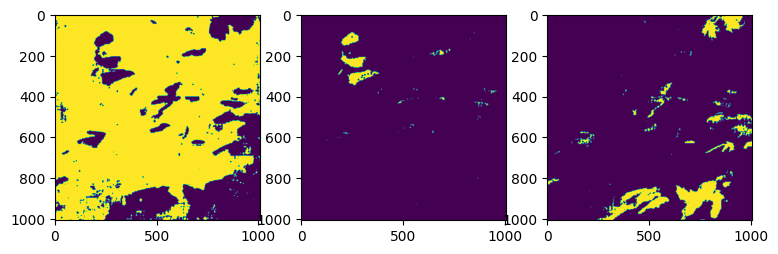

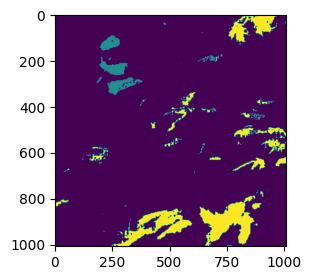

Predicted mask saved at: /content/datasets/predicted_masks/20028206201.png
Quadrat Id in progress:  20029008201


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[173, 259], [167, 157], [310, 321], [129, 304], [357, 120], [472, 345], [577, 249], [583, 118], [598, 216], [451, 296], [498, 248], [862, 287], [912, 155], [1136, 80], [988, 216], [1048, 183], [1212, 131], [1310, 305], [219, 446], [171, 599], [290, 355], [226, 408], [451, 397], [373, 502], [971, 600], [957, 441], [1138, 480], [1178, 400], [1230, 379], [1399, 578], [1438, 591], [1323, 397], [280, 862], [244, 837], [287, 894], [339, 633], [297, 896], [316, 849], [142, 839], [272, 823], [573, 842], [488, 860], [414, 727], [614, 639], [842, 686], [722, 892], [748, 767], [831, 785], [889, 698], [722, 630], [1030, 825], [941, 816], [1031, 763], [933, 642], [1075, 829], [1275, 830], [1406, 800], [1301, 647], [1281, 817], [1196, 831], [1390, 759], [333, 1020], [209, 1163], [153, 929], [461, 1005], [582, 1106], [385, 919], [355, 1067], [667, 1103], [818, 1169], [711, 

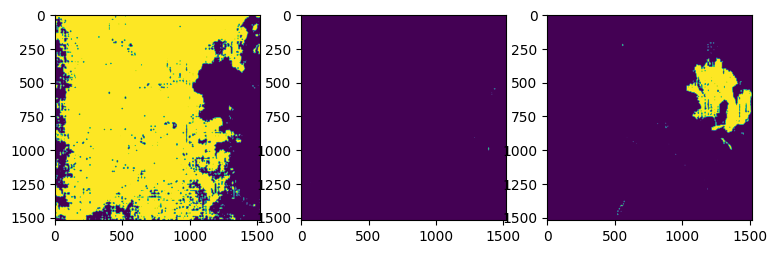

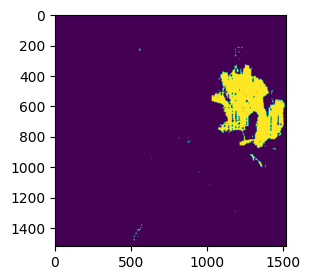

Predicted mask saved at: /content/datasets/predicted_masks/20029008201.png
Quadrat Id in progress:  20031013402


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[149, 130], [162, 150], [135, 62], [198, 73], [335, 112], [241, 174], [453, 51], [409, 52], [471, 182], [626, 90], [669, 135], [821, 126], [702, 165], [688, 160], [775, 71], [203, 315], [154, 226], [102, 221], [245, 222], [212, 209], [361, 262], [287, 334], [353, 242], [261, 256], [345, 271], [274, 297], [290, 365], [418, 333], [482, 358], [449, 275], [483, 265], [451, 318], [435, 239], [488, 224], [523, 357], [643, 270], [729, 265], [746, 345], [707, 355], [784, 333], [114, 433], [99, 493], [312, 395], [218, 416], [225, 516], [459, 368], [471, 392], [412, 479], [391, 378], [501, 376], [668, 512], [588, 467], [602, 458], [806, 501], [767, 495], [712, 496], [804, 425], [803, 439], [733, 517], [179, 664], [179, 654], [127, 604], [64, 683], [160, 572], [180, 581], [197, 635], [104, 653], [305, 526], [233, 639], [286, 569], [334, 608], [311, 550], [339, 567], [30

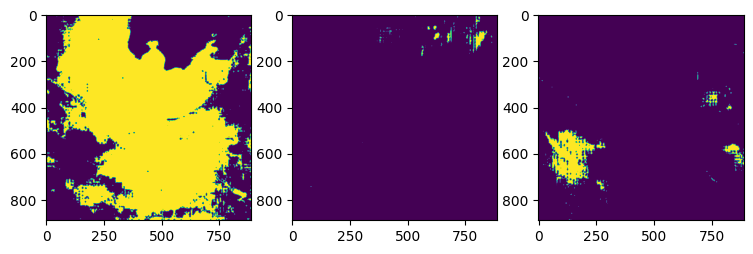

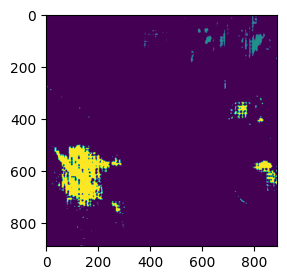

Predicted mask saved at: /content/datasets/predicted_masks/20031013402.png
Quadrat Id in progress:  20031021102


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[199, 147], [316, 90], [329, 211], [363, 48], [255, 139], [290, 167], [542, 73], [394, 112], [471, 76], [695, 145], [663, 197], [602, 160], [796, 185], [157, 314], [198, 336], [141, 265], [275, 285], [234, 311], [278, 355], [331, 290], [224, 350], [292, 253], [235, 309], [519, 235], [476, 221], [421, 275], [392, 355], [547, 379], [576, 336], [565, 320], [611, 247], [810, 281], [720, 259], [752, 221], [319, 547], [284, 497], [345, 517], [481, 481], [420, 387], [547, 503], [476, 490], [599, 470], [663, 535], [702, 404], [565, 390], [614, 435], [612, 516], [578, 450], [771, 388], [754, 441], [872, 520], [863, 388], [852, 400], [734, 506], [159, 586], [96, 598], [196, 601], [285, 585], [321, 549], [224, 620], [380, 634], [346, 602], [484, 605], [492, 635], [476, 653], [447, 617], [591, 555], [712, 702], [549, 622], [557, 669], [765, 554], [839, 555], [791, 630], 

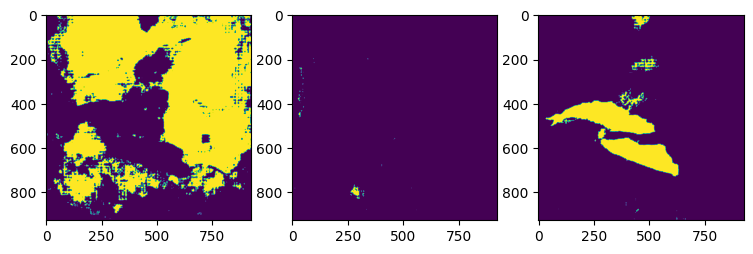

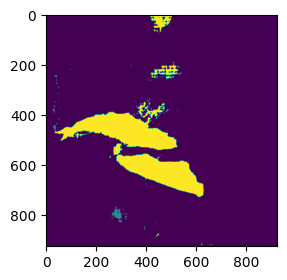

Predicted mask saved at: /content/datasets/predicted_masks/20031021102.png
Quadrat Id in progress:  24027301501


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 150
DEBUG:__main__:Points Coordinates (x,y): [[158, 181], [84, 97], [73, 160], [680, 248], [645, 76], [812, 138], [890, 97], [719, 184], [272, 452], [124, 458], [370, 414], [458, 287], [550, 317], [652, 275], [821, 417], [906, 288], [891, 354], [1005, 457], [1037, 339], [1098, 382], [1090, 406], [1054, 420], [79, 596], [103, 500], [233, 632], [600, 566], [552, 683], [930, 571], [169, 769], [74, 777], [246, 749], [323, 711], [294, 840], [569, 734], [701, 883], [612, 819], [784, 753], [857, 834], [974, 800], [117, 999], [206, 948], [164, 1083], [183, 1052], [313, 1072], [413, 1074], [696, 1077], [901, 948], [884, 1107], [1108, 960], [1128, 1049], [214, 94], [202, 232], [200, 213], [160, 64], [69, 134], [459, 192], [344, 121], [384, 177], [530, 174], [506, 168], [542, 224], [700, 234], [556, 92], [834, 192], [897, 218], [907, 222], [854, 104], [996, 147], [1010, 141], [987, 161], [1083, 105], [1050, 135], [

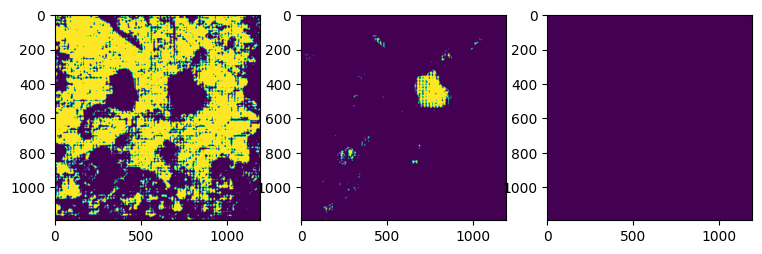

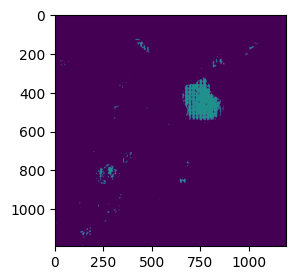

Predicted mask saved at: /content/datasets/predicted_masks/24027301501.png
Quadrat Id in progress:  20046281801


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 100
DEBUG:__main__:Points Coordinates (x,y): [[109, 131], [350, 213], [322, 146], [171, 126], [293, 96], [508, 299], [500, 335], [537, 340], [689, 85], [1054, 115], [957, 166], [995, 307], [1393, 359], [1295, 204], [1381, 85], [1340, 274], [1259, 255], [222, 469], [171, 508], [146, 627], [134, 403], [335, 555], [212, 517], [150, 387], [542, 424], [640, 364], [828, 523], [841, 397], [790, 610], [986, 519], [1188, 577], [1036, 573], [1311, 412], [1356, 556], [1240, 422], [1208, 572], [1375, 581], [128, 704], [100, 861], [133, 865], [167, 768], [448, 801], [606, 655], [582, 687], [542, 853], [874, 750], [861, 839], [642, 833], [713, 832], [969, 894], [964, 799], [1080, 655], [931, 819], [930, 791], [1394, 789], [1373, 704], [1399, 766], [1244, 914], [1226, 685], [338, 1132], [540, 941], [551, 976], [476, 1178], [603, 1060], [789, 930], [872, 1125], [713, 1185], [901, 1061], [871, 1198], [1166, 1122], [1342,

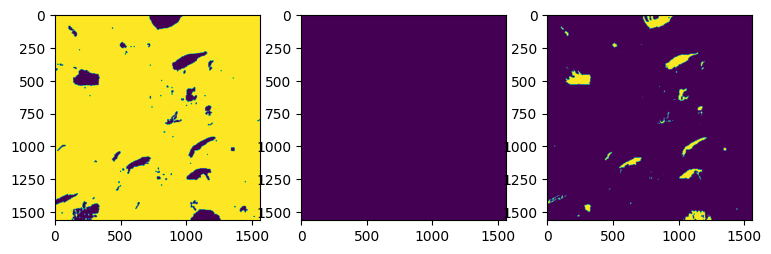

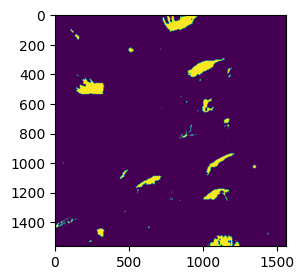

Predicted mask saved at: /content/datasets/predicted_masks/20046281801.png
Quadrat Id in progress:  25016137702


DEBUG:__main__:Positive Class Label: 0
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__main__:Points Coordinates (x,y): [[365, 169], [311, 147], [509, 83], [522, 150], [382, 171], [467, 169], [688, 101], [569, 149], [625, 128], [818, 177], [133, 325], [194, 371], [518, 275], [667, 241], [616, 213], [793, 349], [851, 301], [208, 372], [379, 534], [560, 463], [661, 464], [835, 380], [129, 579], [223, 613], [358, 691], [368, 543], [312, 580], [247, 690], [280, 690], [225, 619], [444, 644], [504, 598], [400, 652], [636, 580], [636, 557], [687, 592], [579, 677], [793, 654], [856, 639], [718, 543], [204, 804], [63, 859], [508, 704], [441, 793], [511, 800], [465, 722], [687, 780], [845, 814], [720, 718], [833, 747]]
DEBUG:__main__:Point Labels: [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
DEBUG:__main__:Positive Class Label: 1
DEBUG:__main__:Number of Point Coordinates: 50
DEBUG:__

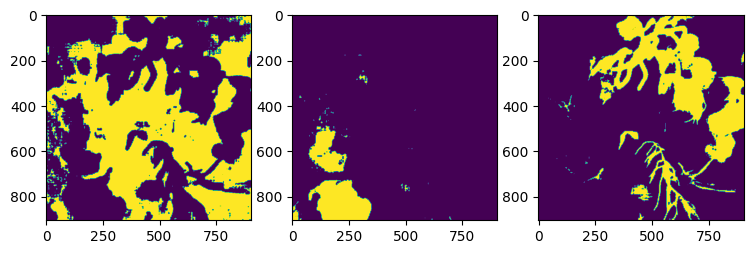

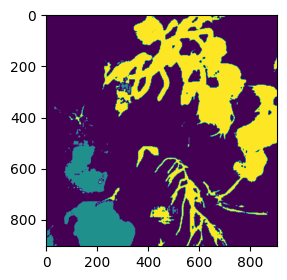

Predicted mask saved at: /content/datasets/predicted_masks/25016137702.png


In [11]:
from PIL import Image
predicted_mask_folder='/content/datasets/predicted_masks'
preprocess_technique='DCP'

val_qudratid=sampled_quadids
for qd in val_qudratid:
  print("Quadrat Id in progress: ",qd)

  point_labels_df_qd=point_labels_df[point_labels_df['quadratid']==qd]

  if point_labels_df_qd is None:
    continue
  image_path = os.path.join(DRIVE_MOUNT_DIR, "My Drive", "preprocessed_images", folder, preprocess_technique, f"{qd}.jpg") # os.path.join(PROJECT_ROOT_DIR, "01_Data", "benthic_datasets", "mask_labels", "reef_support", f"SEAVIEW_{region}", "images", f"{qd}.jpg") #   print(image_path)
  if not os.path.exists(image_path):
    print('->Image not found<-')
    continue
  image = load_image(image_path)
  predictor.set_image(image)

  prompts = []

  for positive_class_label in [0, 1, 2]:
    # if positive_class_label!=0:
      point_coords = []
      point_labels = []

      # build points based prompting parameters using positive and negative labels
      for index, point_label in point_labels_df_qd.iterrows():
          point_coords.append([point_label['x'], point_label['y']])
          if point_label.class_label == positive_class_label:
              point_labels.append(1)
          else:
              point_labels.append(0)

      logger.debug(f"Positive Class Label: {positive_class_label}")
      logger.debug(f"Number of Point Coordinates: {len(point_coords)}")
      logger.debug(f"Points Coordinates (x,y): {point_coords}")
      logger.debug(f"Point Labels: {point_labels}")

      # add positive class label and points details as a prompt
      prompt = dict(class_label=positive_class_label, point_coords=point_coords, point_labels=point_labels)
      prompts.append(prompt)

  for index in range(len(prompts)):
    sam_masks = sam_scores = sam_logits = None

    sam_masks, sam_scores, sam_logits = \
        predictor.predict(
            point_coords=np.array(prompts[index]['point_coords']),
            point_labels=np.array(prompts[index]['point_labels']),
            multimask_output=False,
            )

    prompts[index]['mask'] = sam_masks[0]
    prompts[index]['score'] = sam_scores[0]
    prompts[index]['logits'] = sam_logits[0]
    prompts[index]['logits_min'] = np.min(sam_logits[0])

  sam_logits_stacked = np.array([prompt['logits'] for prompt in prompts])
  sam_logits_stacked.shape

  sam_logits_max = np.argmax(sam_logits_stacked, axis=0)
  sam_logits_max.shape

  for index in range(len(prompts)):
    logits_blended = prompts[index]['logits'][:,:]
    pull_down_indices = np.where(sam_logits_max != index, True, False)
    logits_blended[pull_down_indices] = prompts[index]['logits_min']
    prompts[index]['logits_blended'] = logits_blended[:,:]

  for index in range(len(prompts)):
    post_processed_mask = \
        sam_hq.postprocess_masks(
            masks=torch.from_numpy(prompts[index]['logits_blended']).unsqueeze(dim=0).unsqueeze(dim=0),
            input_size=predictor.input_size,
            original_size=predictor.original_size,
            )

    prompts[index]['mask_blended'] = post_processed_mask.squeeze().numpy() > predictor.model.mask_threshold

  sam_masks_stacked = np.array([prompt['mask_blended'] * prompt['class_label'] for prompt in prompts])
  mask_blended = np.sum(sam_masks_stacked, axis=0)

  fig, ax = plt.subplots(nrows=1, ncols=len(prompts), figsize=(9, 3))
  for index in range(len(prompts)):
      ax[index].imshow(prompts[index]['mask_blended'])
  plt.show()

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
  ax.imshow(mask_blended)
  plt.show()

  # Assuming full_label is a NumPy array, convert it to a PIL Image and save it
  predicted_mask_path = os.path.join(predicted_mask_folder,f'{qd}.png')

  # Convert the NumPy array to a PIL image
  predicted_mask_image = Image.fromarray(mask_blended.astype(np.uint8))

  # Save the image to the specified path
  predicted_mask_image.save(predicted_mask_path)

  print(f"Predicted mask saved at: {predicted_mask_path}")

In [12]:
from pathlib import Path

# Define the base paths for ground truth masks and predicted masks
ground_truth_base_path = os.path.join(PROJECT_ROOT_DIR, "01_Data", "benthic_datasets", "mask_labels", "reef_support", f"SEAVIEW_{region}", "masks_stitched")
predicted_base_path = '/content/datasets/predicted_masks'

# Generate the samples list
samples = []
val_qudratid=sampled_quadids
for quadratid in val_qudratid:
  if not os.path.exists(os.path.join(predicted_base_path, f"{quadratid}.png")):
    print('->Image not found<-')
    continue
  sample = {
        "sample_id": quadratid,  # Unique identifier for the sample
        "mask_path": Path(os.path.join(ground_truth_base_path, f"{quadratid}_mask.png")),  # Ground truth mask path
        "prediction_path": Path(os.path.join(predicted_base_path, f"{quadratid}.png"))  # Predicted mask path
    }
  samples.append(sample)

# Now `samples` will have the dictionaries for each quadratid
print(samples)


[{'sample_id': '17006011402', 'mask_path': PosixPath('/content/drive/My Drive/challenge_2/01_Data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL/masks_stitched/17006011402_mask.png'), 'prediction_path': PosixPath('/content/datasets/predicted_masks/17006011402.png')}, {'sample_id': '17006011602', 'mask_path': PosixPath('/content/drive/My Drive/challenge_2/01_Data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL/masks_stitched/17006011602_mask.png'), 'prediction_path': PosixPath('/content/datasets/predicted_masks/17006011602.png')}, {'sample_id': '17006011802', 'mask_path': PosixPath('/content/drive/My Drive/challenge_2/01_Data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL/masks_stitched/17006011802_mask.png'), 'prediction_path': PosixPath('/content/datasets/predicted_masks/17006011802.png')}, {'sample_id': '17037006802', 'mask_path': PosixPath('/content/drive/My Drive/challenge_2/01_Data/benthic_datasets/mask_labels/reef_support/SEAVIEW_ATL/masks_stitched/17037006802

In [13]:
label_prop = LabelPropEvaluator(experiment_name='SAMHQ')

In [14]:
import seaborn as sns

result = label_prop.evaluate_samples(samples)
# print(result)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: 3 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028
/content/sam-hq/packages/labelmate/evaluator.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.eval_results_samples = pd.concat([self.eval_results_samples, pd.DataFrame([eval_results])])


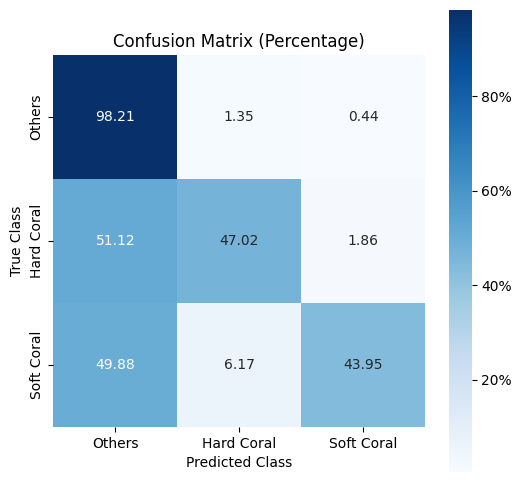

In [15]:
# Initialize an empty confusion matrix (assuming all matrices are of the same size)
combined_confusion_matrix = np.zeros_like(result[0]['confusion_matrix'][0])

# Sum all confusion matrices
for res in result:
    combined_confusion_matrix += res['confusion_matrix'][0]

# Convert the combined confusion matrix to percentages (row-wise normalization)
confusion_matrix_percent = (combined_confusion_matrix / combined_confusion_matrix.sum(axis=1, keepdims=True)) * 100

# Define the class names
class_names = ['Others', 'Hard Coral', 'Soft Coral']

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, class_labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, square=True, cbar_kws={'format': '%.0f%%'})

    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix (Percentage)")
    plt.show()

# Plot the confusion matrix in percentage
plot_confusion_matrix(confusion_matrix_percent, class_names)
